In [1]:
456
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4
# import nc_time_axis
import matplotlib.pyplot as plt
import glob
import cmocean
import xskillscore as xs
import datetime
# from sklearn.metrics import mean_squared_error

import h5py
from scipy.io import loadmat
from scipy import signal
from scipy.interpolate import griddata
import cartopy.crs as ccrs

In [2]:
## Working directory
wrk_dir = '~/work/OBS/dashcams_data/plotting_for_draft_supplementary/'

In [3]:
# load satellite data (2007-2021)

for iy in range(2020,2025):
    print(iy)
    with h5py.File(f'/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/model_satellite/sst_data/sst_{iy}_MUR.mat', 'r') as file:
        def print_attrs(name, obj):
            print(name)
            for key, val in obj.attrs.items():
                print(f"    {key}: {val}")
        
        sst0 = file['sst'][:]
        if iy < 2023:
            sst0=sst0-273.15
        
        # sst_mean = np.nanmean(np.nanmean(sst,axis=1),axis=1)
        if iy==2020:
            sst = sst0
        else:
            sst = np.concatenate((sst,sst0),axis=0)
            
            # sst_mean0 = np.concatenate((sst_mean0,sst_mean),axis=0)
            
        file.visititems(print_attrs)


2020
ilon1
    MATLAB_class: b'double'
jlat1
    MATLAB_class: b'double'
sst
    MATLAB_class: b'double'
2021
ilon1
    MATLAB_class: b'double'
jlat1
    MATLAB_class: b'double'
sst
    MATLAB_class: b'double'
2022
ilon1
    MATLAB_class: b'double'
jlat1
    MATLAB_class: b'double'
sst
    MATLAB_class: b'double'
2023
ilon1
    MATLAB_class: b'double'
jlat1
    MATLAB_class: b'double'
sst
    MATLAB_class: b'double'
2024
ilon1
    MATLAB_class: b'double'
jlat1
    MATLAB_class: b'double'
sst
    MATLAB_class: b'double'


In [4]:
lon0 = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_lonlat_MUR.mat')['lon']
lat0 = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_lonlat_MUR.mat')['lat']

ilon = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_ilon_ilat_MUR.mat')['ilon1']
jlat = loadmat('/home/server/pi/homes/liux8/work/OBS/xliu_obs_process/sst_ilon_ilat_MUR.mat')['jlat1']

lon_mur = lon0[ilon[0,0].astype(int)-1:ilon[-1,0].astype(int)]
lat_mur = lat0[jlat[0,0].astype(int)-1:jlat[-1,0].astype(int)]

In [5]:
tdim = sst.shape[0]
print(tdim)
da_mur = xr.DataArray(sst, coords={'time': np.arange(0,tdim*86400,86400)+50*365*86400+12*86400,'lon': lon_mur[:,0] ,'lat': lat_mur[:,0]},
                  dims=['time','lat','lon'])

# da2_mur = da_mur.interp(lon=datasets_era[0].lonc,lat=datasets_era[0].latc,method='linear')

ds_mur = xr.Dataset({'sst': da_mur})
ds_mur['time'] = pd.to_datetime(ds_mur['time'].values,unit='s')
# ds_dust['time'] = pd.to_datetime(ds_dust['time'].values,unit='s')

1735


# load raw data

## can use NC file below directly

In [251]:
ID_deploy = 'UAEBUSO20'

file1=wrk_dir+f'PG_dive_raw_v1_longrec_keepGPS_{ID_deploy}.csv'; ptime=165
# file1='surf_processed/Jul_Sep_2021.csv'; ptime=220
# file1='surf_processed/Oct_Dec_2021.csv'

# yr=file1[-21:-17]
# yr=file1[-13:-9]
df = pd.read_csv(file1,parse_dates=True,index_col='UTC_datetime')

/tmp/ipykernel_2645486/3571139322.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file1,parse_dates=True,index_col='UTC_datetime')


In [252]:
df[(pd.to_datetime(df['date'])>=pd.to_datetime('2021-5-15 3:36'))&(pd.to_datetime(df['date'])<=pd.to_datetime('2021-5-15 9:42'))]

device_id    UTC_date  UTC_time datatype satcount  \
UTC_datetime                                                             
2021-05-15 03:50:44     203018  2021-05-15  03:50:44     GPSS     11.0   
2021-05-15 04:10:45     203018  2021-05-15  04:10:45     GPSS      9.0   
2021-05-15 04:30:45     203018  2021-05-15  04:30:45     GPSS      9.0   
2021-05-15 04:50:44     203018  2021-05-15  04:50:44     GPSS      9.0   
2021-05-15 05:10:44     203018  2021-05-15  05:10:44     GPSS     10.0   
...                        ...         ...       ...      ...      ...   
2021-05-15 08:13:47     201411  2021-05-15  08:13:47     GPSD      6.0   
2021-05-15 08:33:47     201411  2021-05-15  08:33:47     GPSD      7.0   
2021-05-15 08:53:47     201411  2021-05-15  08:53:47      GPS      7.0   
2021-05-15 09:13:48     201411  2021-05-15  09:13:48      GPS      6.0   
2021-05-15 09:33:49     201411  2021-05-15  09:33:49      GPS      7.0   

                      Latitude  Longitude  int_temperature_C  \
UTC_datetime                                                   
2021-05-15 03:50:44  25.253420  55.180595               42.0   
2021-05-15 04:10:45  25.253160  55.180298               45.0   
2021-05-15 04:30:45  25.251207  55.177139               32.0   
2021-05-15 04:50:44  25.251192  55.177551               42.0   
2021-05-15 05:10:44  25.251369  55.177410               47.0   
...                        ...        ...                ...   
2021-05-15 08:13:47  25.251188  55.177589               40.0   
2021-05-15 08:33:47  25.251490  55.177437               40.0   
2021-05-15 08:53:47  25.251476  55.177315               41.0   
2021-05-15 09:13:48  25.251493  55.177319               39.0   
2021-05-15 09:33:49  25.251810  55.177074               39.0   

                               UTC_timestamp  milliseconds  depth_m  \
UTC_datetime                                                          
2021-05-15 03:50:44  2021-05-15 03:50:44.896         896.0      NaN   
2021-05-15 04:10:45  2021-05-15 04:10:45.853         853.0      NaN   
2021-05-15 04:30:45  2021-05-15 04:30:45.882         882.0      NaN   
2021-05-15 04:50:44  2021-05-15 04:50:44.899         899.0      NaN   
2021-05-15 05:10:44  2021-05-15 05:10:44.889         889.0      NaN   
...                                      ...           ...      ...   
2021-05-15 08:13:47  2021-05-15 08:13:47.611         611.0      NaN   
2021-05-15 08:33:47  2021-05-15 08:33:47.628         628.0      NaN   
2021-05-15 08:53:47  2021-05-15 08:53:47.629         629.0      NaN   
2021-05-15 09:13:48  2021-05-15 09:13:48.627         627.0      NaN   
2021-05-15 09:33:49  2021-05-15 09:33:49.626         626.0      NaN   

                     ext_temperature_C                 date  
UTC_datetime                                                 
2021-05-15 03:50:44                NaN  2021-05-15 03:50:44  
2021-05-15 04:10:45                NaN  2021-05-15 04:10:45  
2021-05-15 04:30:45                NaN  2021-05-15 04:30:45  
2021-05-15 04:50:44                NaN  2021-05-15 04:50:44  
2021-05-15 05:10:44                NaN  2021-05-15 05:10:44  
...                                ...                  ...  
2021-05-15 08:13:47                NaN  2021-05-15 08:13:47  
2021-05-15 08:33:47                NaN  2021-05-15 08:33:47  
2021-05-15 08:53:47                NaN  2021-05-15 08:53:47  
2021-05-15 09:13:48                NaN  2021-05-15 09:13:48  
2021-05-15 09:33:49                NaN  2021-05-15 09:33:49  

[1298 rows x 13 columns]

In [253]:
df['t'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['milliseconds'], unit='ms')

In [254]:
df['date2'] = df['t']
df = df.set_index('t')
df

device_id    UTC_date  UTC_time  \
t                                                          
2020-11-02 20:11:05.000     203018  2020-11-02  20:11:05   
2020-11-02 22:14:06.000     203018  2020-11-02  22:14:06   
2020-11-02 22:19:19.100     203018  2020-11-02  22:19:19   
2020-11-02 22:19:19.200     203018  2020-11-02  22:19:19   
2020-11-02 22:19:19.300     203018  2020-11-02  22:19:19   
...                            ...         ...       ...   
2021-08-13 22:22:22.000     201411  2021-08-13  22:22:22   
2021-08-14 01:22:22.000     201411  2021-08-14  01:22:22   
2021-08-14 04:22:22.000     201411  2021-08-14  04:22:22   
2021-08-14 04:51:17.000     201411  2021-08-14  04:51:17   
2021-08-14 19:26:56.000     201411  2021-08-14  19:26:56   

                                     datatype satcount  Latitude  Longitude  \
t                                                                             
2020-11-02 20:11:05.000                   GPS      6.0   44.5583  -123.2715   
2020-11-02 22:14:06.000                   GPS      0.0    0.0000     0.0000   
2020-11-02 22:19:19.100  SEND_ALL2_10Hz_START      NaN       NaN        NaN   
2020-11-02 22:19:19.200        SEND_ALL2_10Hz      NaN       NaN        NaN   
2020-11-02 22:19:19.300        SEND_ALL2_10Hz      NaN       NaN        NaN   
...                                       ...      ...       ...        ...   
2021-08-13 22:22:22.000                  GPSS      0.0    0.0000     0.0000   
2021-08-14 01:22:22.000                  GPSS      0.0    0.0000     0.0000   
2021-08-14 04:22:22.000                  GPSS      0.0    0.0000     0.0000   
2021-08-14 04:51:17.000                  GPSS      0.0    0.0000     0.0000   
2021-08-14 19:26:56.000                   GPS      0.0    0.0000     0.0000   

                         int_temperature_C  \
t                                            
2020-11-02 20:11:05.000               16.0   
2020-11-02 22:14:06.000               26.0   
2020-11-02 22:19:19.100                NaN   
2020-11-02 22:19:19.200                NaN   
2020-11-02 22:19:19.300                NaN   
...                                    ...   
2021-08-13 22:22:22.000               43.0   
2021-08-14 01:22:22.000               43.0   
2021-08-14 04:22:22.000               43.0   
2021-08-14 04:51:17.000               43.0   
2021-08-14 19:26:56.000               44.0   

                                                       UTC_timestamp  \
t                                                                      
2020-11-02 20:11:05.000                      2020-11-02 20:11:05.000   
2020-11-02 22:14:06.000                      2020-11-02 22:14:06.000   
2020-11-02 22:19:19.100  2020-11-02 22:19:19.2020-11-02 22:19:19.100   
2020-11-02 22:19:19.200  2020-11-02 22:19:19.2020-11-02 22:19:19.200   
2020-11-02 22:19:19.300  2020-11-02 22:19:19.2020-11-02 22:19:19.300   
...                                                              ...   
2021-08-13 22:22:22.000                      2021-08-13 22:22:22.000   
2021-08-14 01:22:22.000                      2021-08-14 01:22:22.000   
2021-08-14 04:22:22.000                      2021-08-14 04:22:22.000   
2021-08-14 04:51:17.000                      2021-08-14 04:51:17.000   
2021-08-14 19:26:56.000                      2021-08-14 19:26:56.000   

                         milliseconds  depth_m  ext_temperature_C  \
t                                                                   
2020-11-02 20:11:05.000           0.0      NaN                NaN   
2020-11-02 22:14:06.000           0.0      NaN                NaN   
2020-11-02 22:19:19.100         100.0     0.58          14.671875   
2020-11-02 22:19:19.200         200.0     0.64          14.429688   
2020-11-02 22:19:19.300         300.0     0.69          14.250000   
...                               ...      ...                ...   
2021-08-13 22:22:22.000           0.0      NaN                NaN   
2021-08-14 01:22:22.000           0.0      NaN             

In [10]:
df[(df['date2']>=pd.to_datetime('2021-5-23 1:21'))&(df['date2']<=pd.to_datetime('2021-5-23 6:50'))]

device_id    UTC_date  UTC_time datatype satcount  \
t                                                                            
2021-05-23 01:25:36.000     203018  2021-05-23  01:25:36     GPSD      8.0   
2021-05-23 01:45:36.662     203018  2021-05-23  01:45:36     GPSD      9.0   
2021-05-23 02:05:36.646     203018  2021-05-23  02:05:36     GPSD      8.0   
2021-05-23 02:25:35.596     203018  2021-05-23  02:25:35     GPSD      8.0   
2021-05-23 02:45:37.000     203018  2021-05-23  02:45:37     GPSD      9.0   
...                            ...         ...       ...      ...      ...   
2021-05-23 06:23:06.000     201411  2021-05-23  06:23:06     GPSD     14.0   
2021-05-23 06:23:07.000     201411  2021-05-23  06:23:07     GPSD     12.0   
2021-05-23 06:23:08.000     201411  2021-05-23  06:23:08     GPSD     13.0   
2021-05-23 06:25:22.000     201411  2021-05-23  06:25:22     GPSD     14.0   
2021-05-23 06:45:29.207     201411  2021-05-23  06:45:29     GPSD      9.0   

                          Latitude  Longitude            UTC_timestamp  \
t                                                                        
2021-05-23 01:25:36.000  25.252386  55.176315  2021-05-23 01:25:36.000   
2021-05-23 01:45:36.662  25.252392  55.176651  2021-05-23 01:45:36.662   
2021-05-23 02:05:36.646  25.252457  55.176556  2021-05-23 02:05:36.646   
2021-05-23 02:25:35.596  25.252579  55.176250  2021-05-23 02:25:35.596   
2021-05-23 02:45:37.000  25.252506  55.176598  2021-05-23 02:45:37.000   
...                            ...        ...                      ...   
2021-05-23 06:23:06.000  25.236813  55.101410  2021-05-23 06:23:06.000   
2021-05-23 06:23:07.000  25.236820  55.101410  2021-05-23 06:23:07.000   
2021-05-23 06:23:08.000  25.236826  55.101406  2021-05-23 06:23:08.000   
2021-05-23 06:25:22.000  25.237217  55.101036  2021-05-23 06:25:22.000   
2021-05-23 06:45:29.207  25.209799  55.054501  2021-05-23 06:45:29.207   

                         milliseconds  depth_m  ext_temperature_C  \
t                                                                   
2021-05-23 01:25:36.000           0.0      NaN                NaN   
2021-05-23 01:45:36.662         662.0      NaN                NaN   
2021-05-23 02:05:36.646         646.0      NaN                NaN   
2021-05-23 02:25:35.596         596.0      NaN                NaN   
2021-05-23 02:45:37.000           0.0      NaN                NaN   
...                               ...      ...                ...   
2021-05-23 06:23:06.000           0.0      NaN                NaN   
2021-05-23 06:23:07.000           0.0      NaN                NaN   
2021-05-23 06:23:08.000           0.0      NaN                NaN   
2021-05-23 06:25:22.000           0.0      NaN                NaN   
2021-05-23 06:45:29.207         207.0      NaN                NaN   

                                        date                   date2  
t                                                                     
2021-05-23 01:25:36.000  2021-05-23 01:25:36 2021-05-23 01:25:36.000  
2021-05-23 01:45:36.662  2021-05-23 01:45:36 2021-05-23 01:45:36.662  
2021-05-23 02:05:36.646  2021-05-23 02:05:36 2021-05-23 02:05:36.646  
2021-05-23 02:25:35.596  2021-05-23 02:25:35 2021-05-23 02:25:35.596  
2021-05-23 02:45:37.000  2021-05-23 02:45:37 2021-05-23 02:45:37.000  
...                                      ...                     ...  
2021-05-23 06:23:06.000  2021-05-23 06:23:06 2021-05-23 06:23:06.000  
2021-05-23 06:23:07.000  2021-05-23 06:23:07 2021-05-23 06:23:07.000  
2021-05-23 06:23:08.000  2021-05-23 06:23:08 2021-05-23 06:23:08.000  
2021-05-23 06:25:22.000  2021-05-23 06:25:22 2021-05-23 06:25:22.000  
2021-05-23 06:45:29.207  2021-05-23 06:45:29 2021-05-23 06:45:29.207  

[1116 rows x 13 columns]

In [255]:
# df1 = df.loc[df['device_id']==203013]

# x = xr.DataArray(df.Longitude_1, dims="t")
# y = xr.DataArray(df.Latitude_1, dims="t")
time = xr.DataArray(df.date2, dims="t")
did = xr.DataArray(df.device_id, dims="t")
# accx = xr.DataArray(df.acc_x,dims='t')
# accy = xr.DataArray(df.acc_y,dims='t')
# accz = xr.DataArray(df.acc_z,dims='t')
lon = xr.DataArray(df.Longitude,dims='t')
lat = xr.DataArray(df.Latitude,dims='t')
datatype = xr.DataArray(df.datatype,dims='t')
depth = xr.DataArray(df.depth_m,dims='t')
temp = xr.DataArray(df.ext_temperature_C, dims="t")
# conduc = xr.DataArray(df['conductivity_mS/cm'], dims="t")

ds_obs = xr.Dataset({
    # 'x': x,
    # 'y': y,
    'time': time,
    'id': did,
    # 'accx': accx,
    # 'accy': accy,
    # 'accz': accz,
    'lon': lon,
    'lat': lat,
    'datatype': datatype,
    'depth': depth,
    'temp': temp,
    # 'cond': conduc
})

In [256]:
ds_obs.to_netcdf('PG_acc_raw_v1_keep_gps_UAEBUSO20.nc')

# load NC files

In [7]:
ds_obs = xr.open_dataset(wrk_dir+'PG_acc_raw_v1_keep_gps_BAHHASO23.nc',mode='r')
ds_obs

<xarray.Dataset>
Dimensions:   (t: 16614684)
Coordinates:
  * t         (t) datetime64[ns] 2023-11-03T07:11:53 ... 2024-04-27T01:20:03
Data variables:
    time      (t) datetime64[ns] ...
    id        (t) int64 ...
    lon       (t) float64 ...
    lat       (t) float64 ...
    datatype  (t) object ...
    depth     (t) float64 ...
    temp      (t) float64 ...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


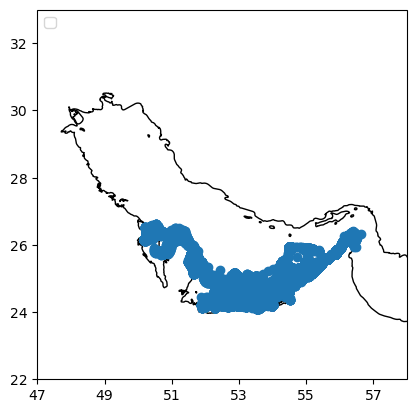

In [257]:
### OLD version
ax = plt.axes(projection=ccrs.PlateCarree())
plt.plot(ds_obs.lon,ds_obs.lat,'o')

ax.coastlines()
ax.set_xlim(47,58)
ax.set_ylim(22,33)
ax.set_xticks(np.arange(47,58,2), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(22,33,2), crs=ccrs.PlateCarree())
ax.legend(loc = "upper left")

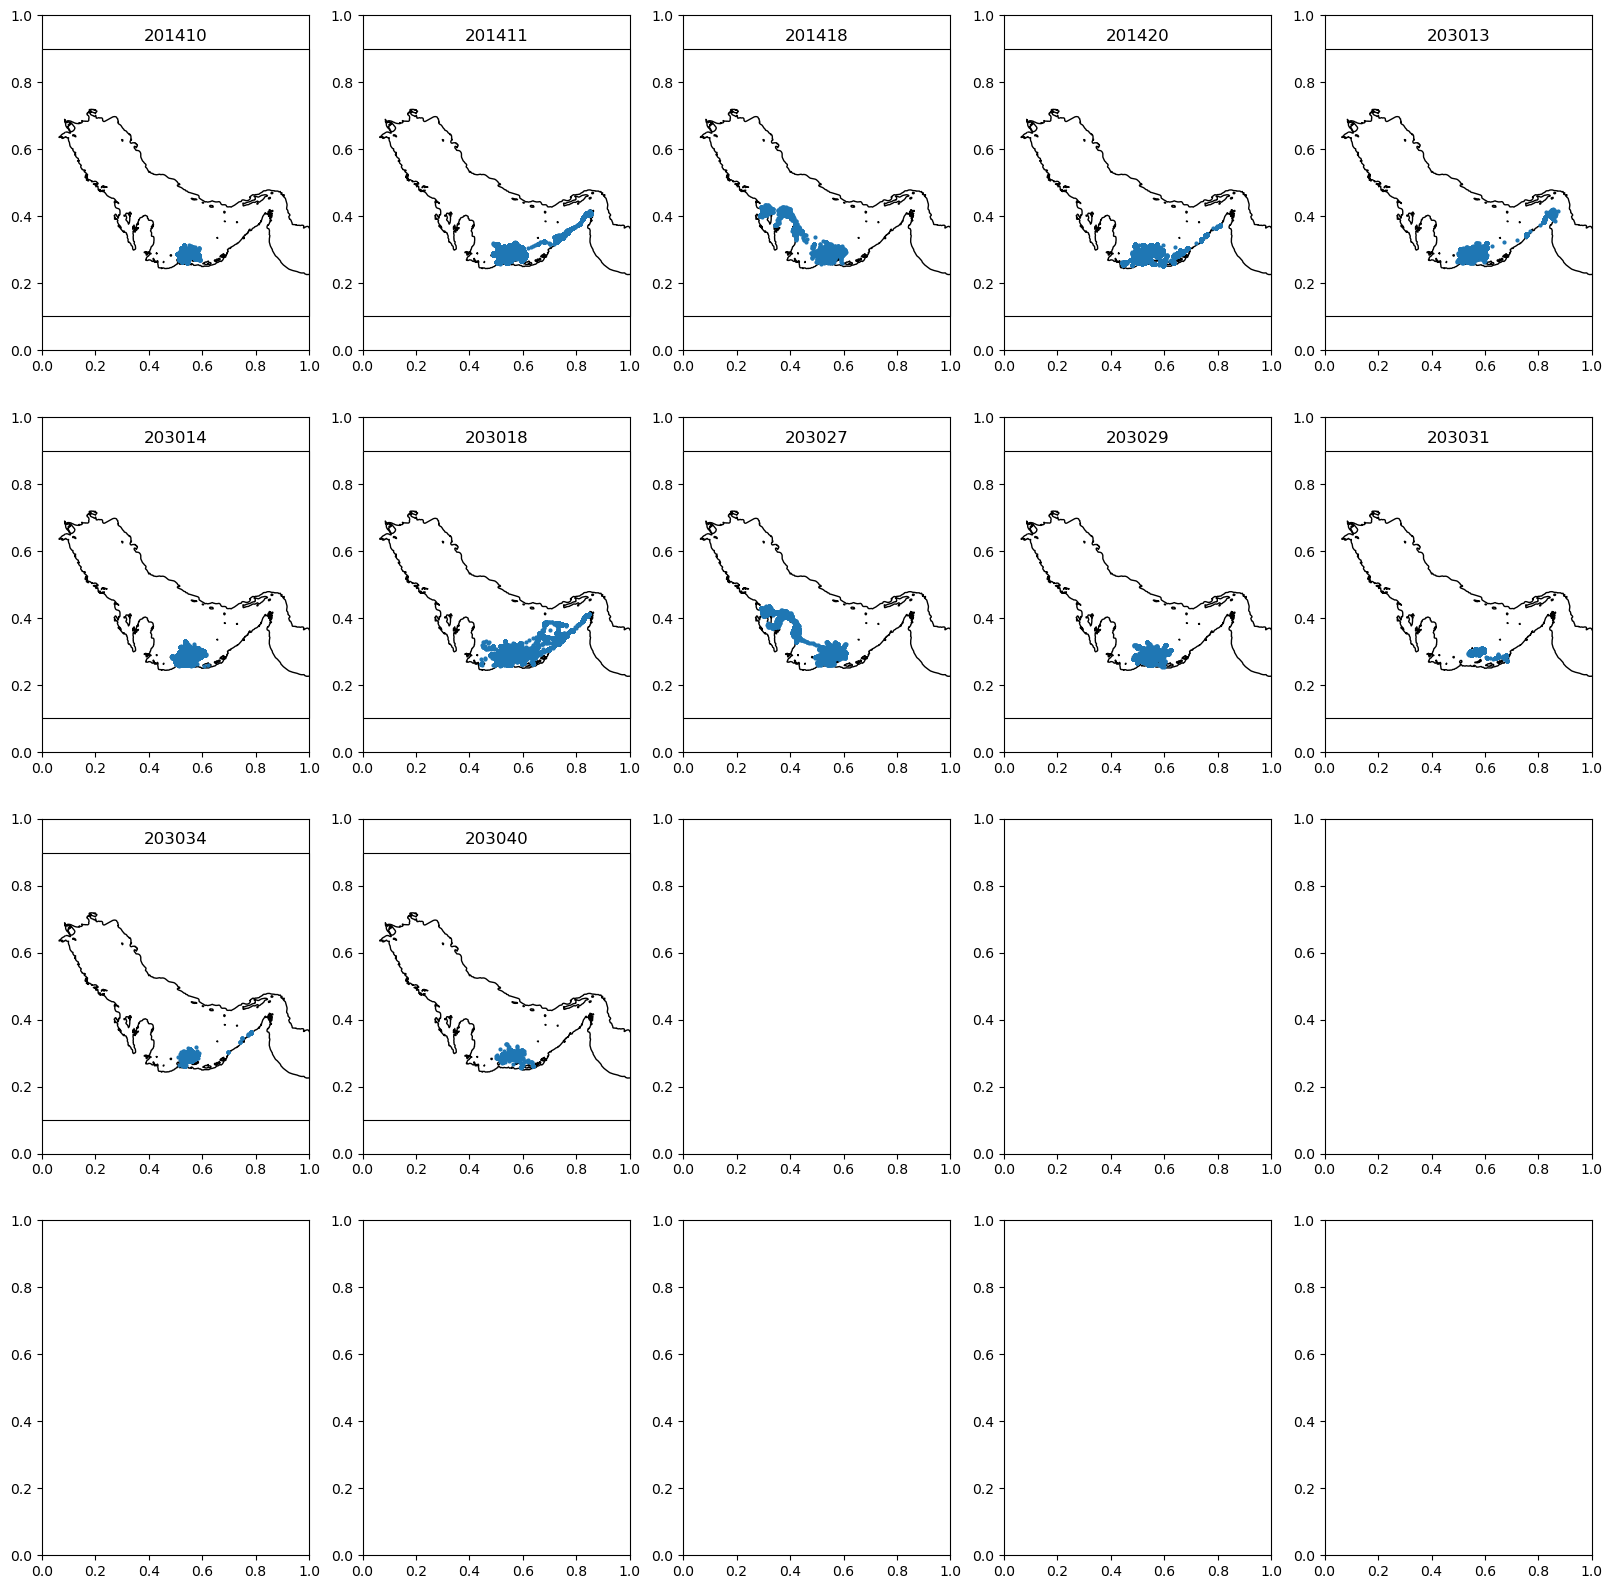

In [258]:
fig,axs = plt.subplots(4,5,figsize=(20,20))
iplt = 0
for i in np.unique(ds_obs.id):
    ax = plt.subplot(4, 5, iplt + 1, projection=ccrs.PlateCarree())
    # ax = plt.axes(projection=ccrs.PlateCarree())
    plt.plot(ds_obs.lon.where(ds_obs.id==i),ds_obs.lat,'o',markersize=2)
    # plt.plot([x_geobox[0],x_geobox[0],x_geobox[1],x_geobox[1],x_geobox[0]],[y_geobox[1],y_geobox[0],y_geobox[0],y_geobox[1],y_geobox[1]])

    ax.coastlines()
    ax.set_xlim(47,58)
    ax.set_ylim(22,33)
    ax.set_title(i)
    iplt += 1
    # ax.set_xlim(x_geobox[0]-0.1,x_geobox[1]+0.1)
    # ax.set_ylim(y_geobox[0]-0.1,y_geobox[1]+0.1)

In [16]:
print( 'tags in the Persian Gulf:' , np.unique(ds_obs.id),len(np.unique(ds_obs.id)))
print( 'tags in the Persian Gulf:' , np.unique(ds_obs.datatype),len(np.unique(ds_obs.datatype)))

tags in the Persian Gulf: [201410 201411 201418 201420 203013 203014 203018 203027 203029 203031
 203034 203040] 12
tags in the Persian Gulf: ['GPS' 'GPSD' 'GPSF' 'GPSS' 'NOTE_DIVING' 'SEND_ALL2_10Hz'
 'SEND_ALL2_10Hz_END' 'SEND_ALL2_10Hz_START' 'SEND_ALL2_10Hz_START_END'
 'SEND_ALL2_1Hz' 'SEND_ALL2_1Hz_END' 'SEND_ALL2_1Hz_START'
 'SEND_ALL2_1Hz_START_END' 'SEN_ACC_5Hz_START_ENDINT' 'SEN_ALL_1Hz'
 'SEN_ALL_1Hz_END' 'SEN_ALL_1Hz_START'] 17


201410
<xarray.DataArray 'time' (t: 293315)>
array(['2020-07-02T01:07:14.000000000', '2020-07-02T01:07:15.000000000',
       '2020-07-02T01:07:49.151000000', ...,
       '2021-07-13T07:39:39.719000000', '2021-07-13T07:59:39.763000000',
       '2021-07-13T08:19:39.793000000'], dtype='datetime64[ns]')
Coordinates:
  * t        (t) datetime64[ns] 2020-07-02T01:07:14 ... 2021-07-13T08:19:39.7...
201411
<xarray.DataArray 'time' (t: 593889)>
array(['2020-07-02T00:33:35.000000000', '2020-07-02T00:33:36.000000000',
       '2020-07-02T00:34:11.427000000', ...,
       '2021-08-14T04:22:22.000000000', '2021-08-14T04:51:17.000000000',
       '2021-08-14T19:26:56.000000000'], dtype='datetime64[ns]')
Coordinates:
  * t        (t) datetime64[ns] 2020-07-02T00:33:35 ... 2021-08-14T19:26:56
201418
<xarray.DataArray 'time' (t: 179776)>
array(['2020-07-02T01:03:44.000000000', '2020-07-02T01:03:45.000000000',
       '2020-07-02T01:03:46.000000000', ...,
       '2023-03-09T04:16:05.000000000', '2023-03-11T

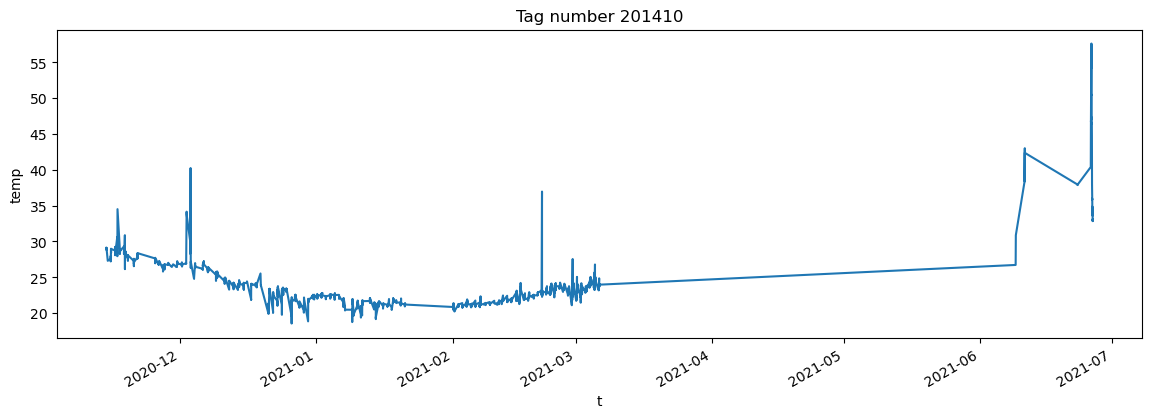

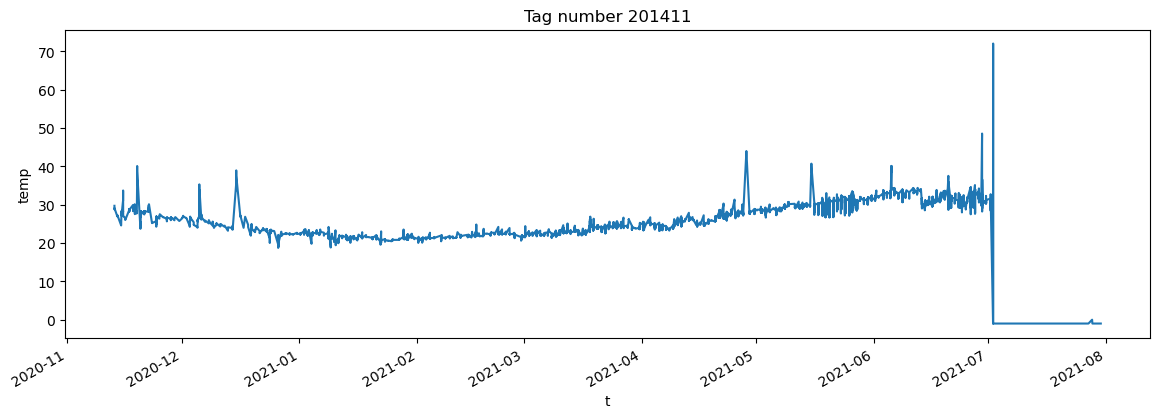

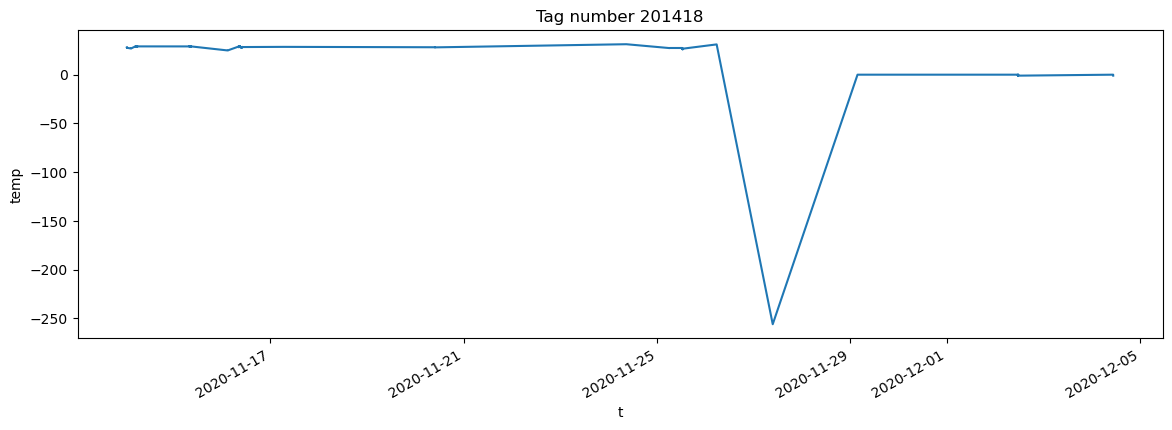

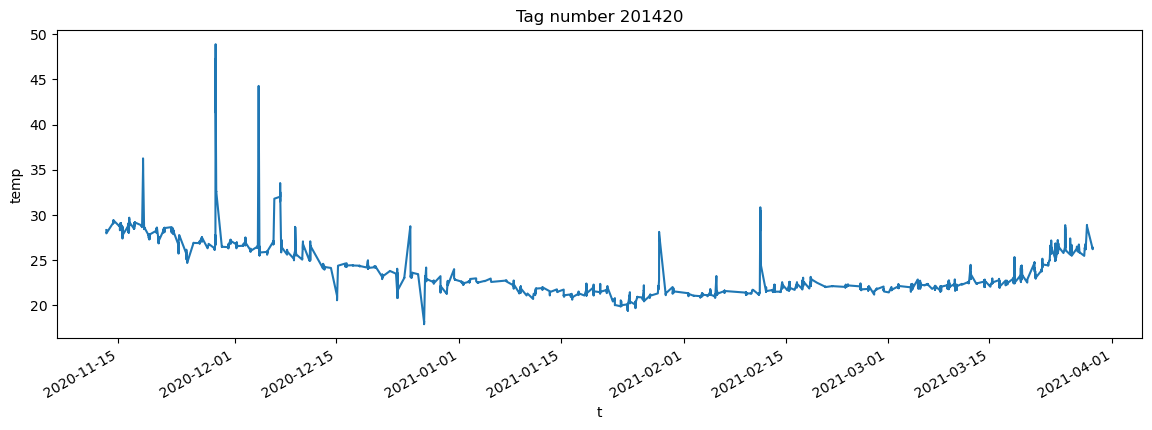

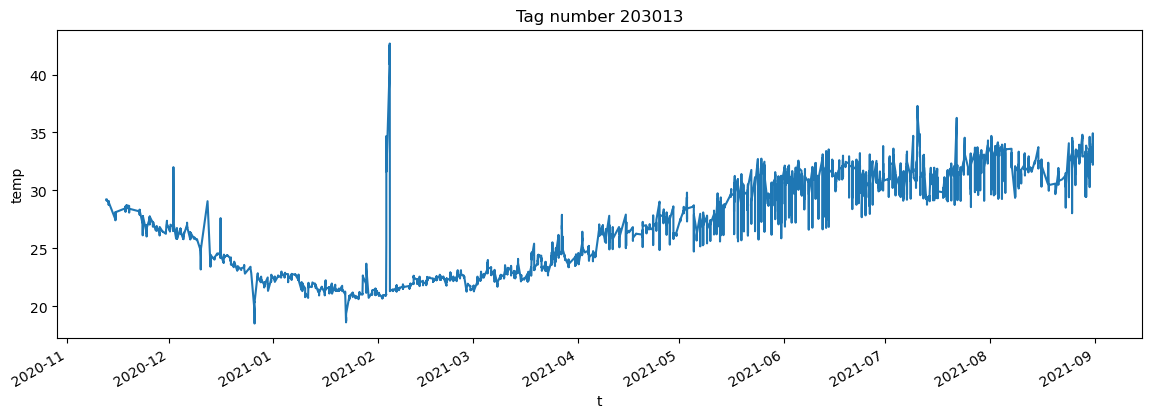

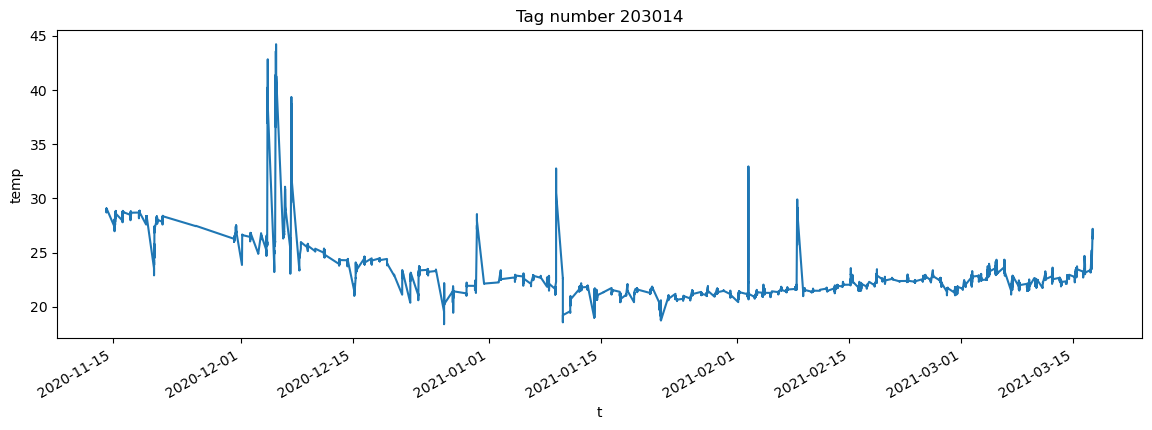

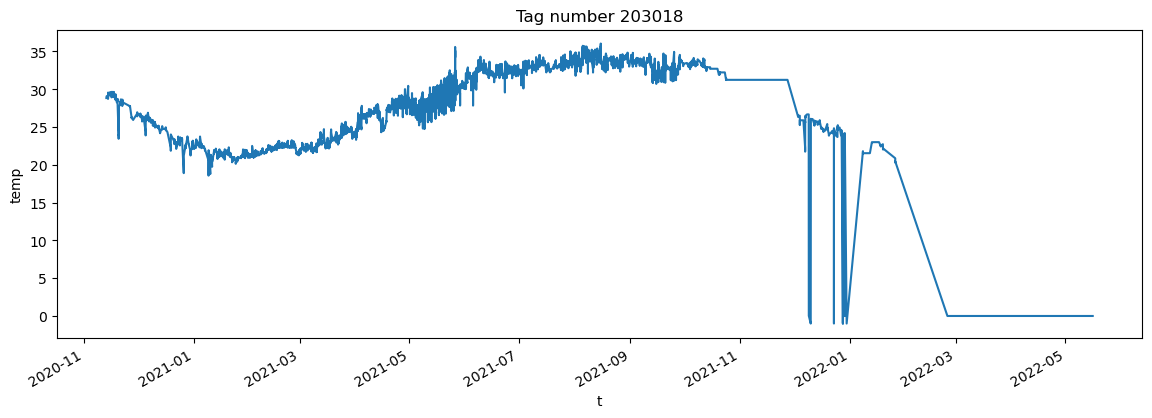

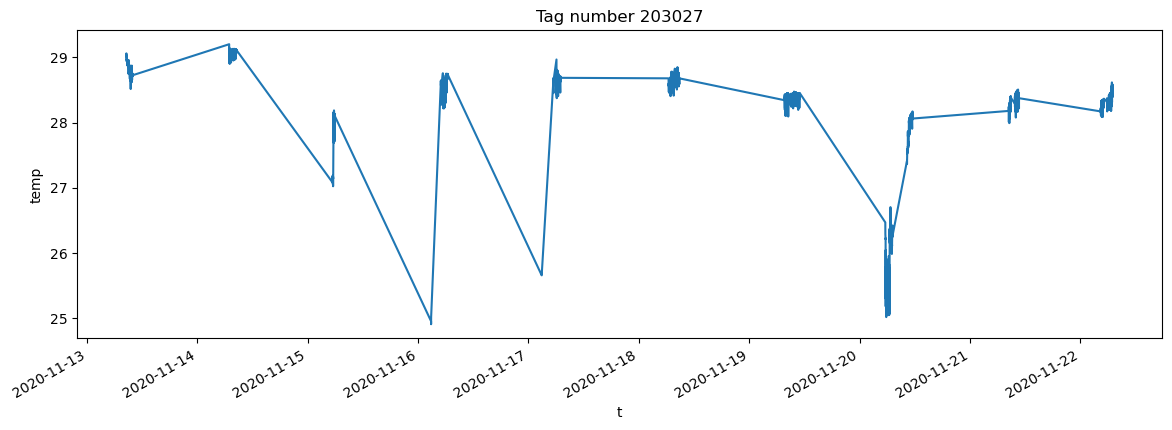

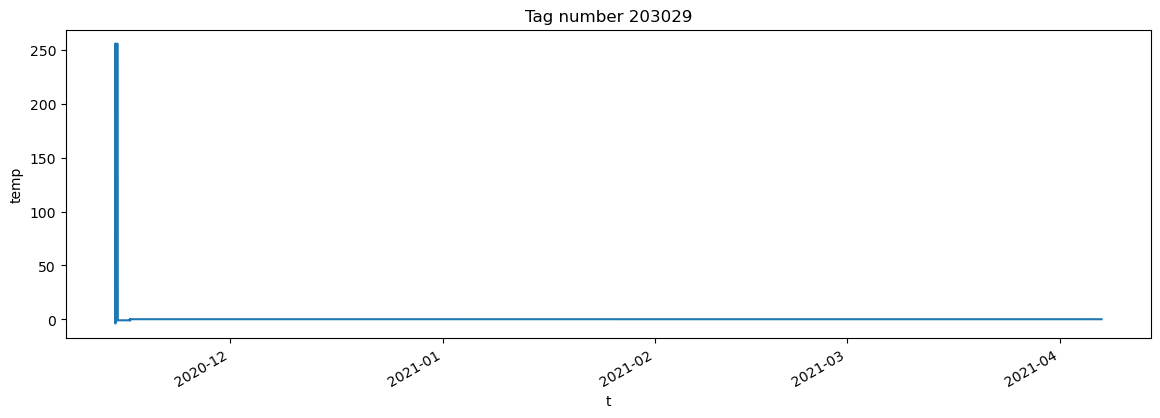

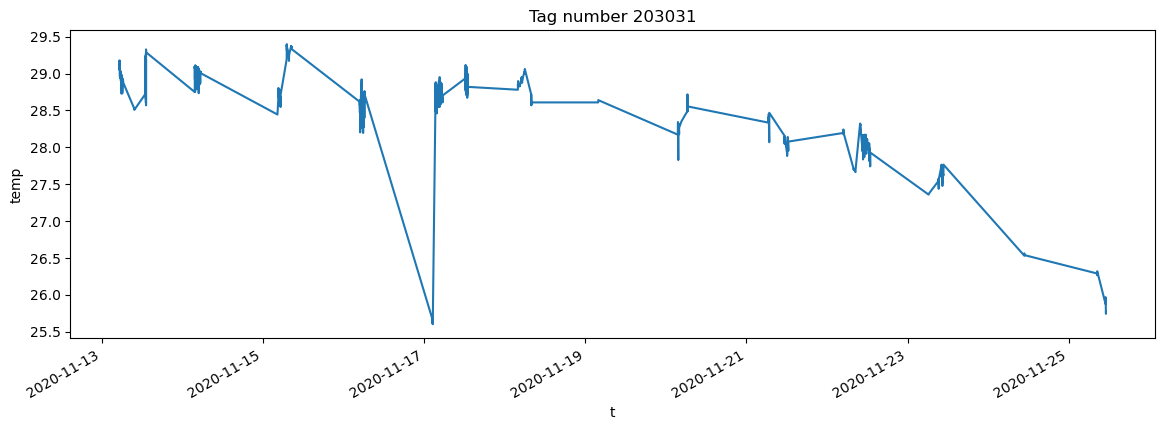

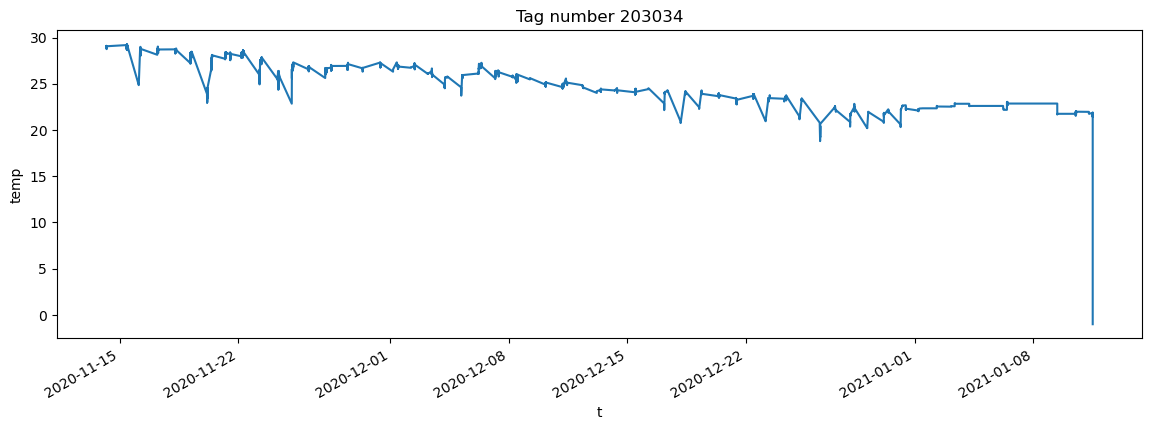

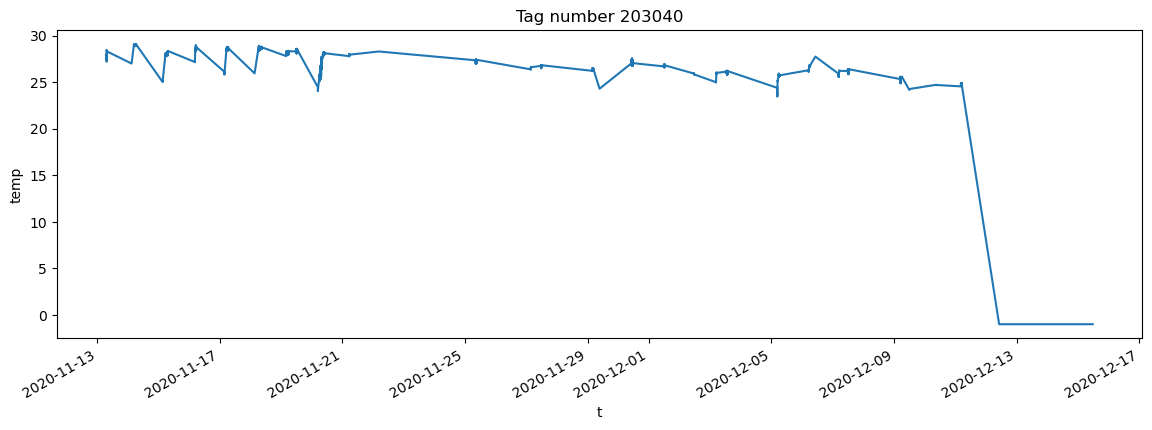

In [17]:
for i in np.unique(ds_obs.id):
    print(i)
    ds_obs_1 = ds_obs.where((ds_obs.id == i),drop=True)
    print(ds_obs_1.time)
    plt.figure(figsize=(14,4))
    ds_obs_1.where(ds_obs_1.datatype=='SEND_ALL2_1Hz',drop=True).temp.plot()
    plt.title(f'Tag number {i}')

    # break

# calculate the total number of SEND_ALL2_1HZ, data for all tags

## Take TAG 237244 as an example

201410
201411
201418
201420
203013
203014
203018
203027
203029
203031
203034
203040


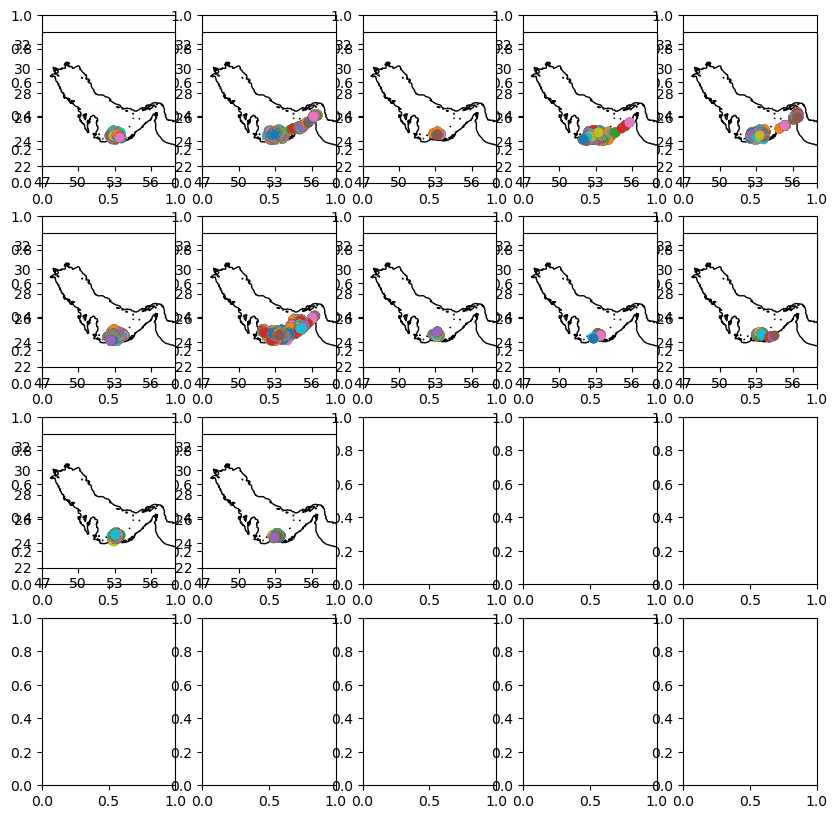

In [18]:
# pick a tag with its id number 191989
# ds_obs_1 is the dataset for the tag 191989

# pd_dive_2 = pd.DataFrame(columns=['ik', 'temp0', 'temp1', 'rec_len','first_record','last_record'])
ds_dive_2 = xr.Dataset(
    {
        'tag_id': ('dive_index', np.array([])),
        'temp1': ('dive_index', np.array([])),
        'temp0': ('dive_index', np.array([])),
        'rec_len': ('dive_index', np.array([])),
        'first_record': ('dive_index', np.array([])),
        'last_record': ('dive_index', np.array([]))
    },
    coords={'dive_index': np.array([])}
)

fig,axs = plt.subplots(4,5,figsize=(10,10))
iplt = 0
for idn in np.unique(ds_obs.id):
    print(idn)
    # create ds_obs_1 for one tag
    ds_obs_1 = ds_obs.where((ds_obs.id == idn),drop=True)
    # Create a new integer coordinate
    new_t = np.arange(len(ds_obs_1['t']))

    # Optionally, store the original time as a data variable for reference
    ds_obs_1 = ds_obs_1.assign(original_time=('time_index', ds_obs_1['t'].values))

    # Assign the new integer coordinate while keeping the original as a variable
    ds_obs_1 = ds_obs_1.assign_coords(t=new_t).rename({'t': 'time_index'})

    # assign a new variable 'mask' (with NaNs)
    ds_obs_1 = ds_obs_1.assign(mask=(('time_index',), np.full(ds_obs_1.dims['time_index'], np.nan)))

    # Find the indices where 'datatype' is 'GPS'
    # list the "indices" where the difference between two consecutive indices is greater than 10
    # assign a new mask for each of these indices

    gps_indices = ds_obs_1.time_index.where((ds_obs_1.datatype == 'GPS')|(ds_obs_1.datatype == 'GPSS')|(ds_obs_1.datatype == 'GPSD'), drop=True).values.astype(int)

    indices = [(i, j, j-i) for i, j in zip(gps_indices[:-1], gps_indices[1:]) if j - i > 10]
    imask = 0
    for idx in indices:
        # print(idx)
        ds_obs_1['mask'].loc[dict(time_index=slice(idx[0], idx[1]))] = imask
        imask = imask+1
    
    # for each chunk between two GPS records, find the indices where the datatype is 'SEND_ALL2_1Hz'
    imask = 0


    # Define indices_inbox list
    ds_obs_1['mask2'] = xr.DataArray(np.zeros(ds_obs_1.dims['time_index']), dims='time_index')
    ds_obs_1['lon_bef'] = xr.DataArray(np.zeros(ds_obs_1.dims['time_index']), dims='time_index')
    ds_obs_1['lat_bef'] = xr.DataArray(np.zeros(ds_obs_1.dims['time_index']), dims='time_index')
    ds_obs_1['lon_end'] = xr.DataArray(np.zeros(ds_obs_1.dims['time_index']), dims='time_index')
    ds_obs_1['lat_end'] = xr.DataArray(np.zeros(ds_obs_1.dims['time_index']), dims='time_index')

    ax = plt.subplot(4, 5, iplt + 1, projection=ccrs.PlateCarree())
    # first find the indices whose GPS location is in the box
    for idx in indices:
        p1 = ds_obs_1.isel(time_index=idx[0])
        p2 = ds_obs_1.isel(time_index=idx[1])

        if 'SEND_ALL2_1Hz' in ds_obs_1.datatype.isel(time_index=slice(idx[0], idx[1])).values:
            # Find pairs of 'SEND_ALL2_1Hz_START' and 'SEND_ALL2_1Hz_END' in ds_obs_1.datatype.isel(time_index=slice(idx[0], idx[1]))
            start_indices = ds_obs_1.time_index.where(ds_obs_1.datatype.isel(time_index=slice(idx[0], idx[1])) == 'SEND_ALL2_1Hz_START', drop=True).values.astype(int)
            end_indices = ds_obs_1.time_index.where(ds_obs_1.datatype.isel(time_index=slice(idx[0], idx[1])) == 'SEND_ALL2_1Hz_END', drop=True).values.astype(int)
            
            # Ensure that each start has a corresponding end
            for start, end in zip(start_indices, end_indices):
                if start < end:
                    ds_obs_1['mask2'].loc[dict(time_index=slice(start, end))] = imask
                    ds_obs_1['lon_bef'].loc[dict(time_index=slice(start, end))] = p1.lon.values
                    ds_obs_1['lat_bef'].loc[dict(time_index=slice(start, end))] = p1.lat.values
                    ds_obs_1['lon_end'].loc[dict(time_index=slice(start, end))] = p2.lon.values
                    ds_obs_1['lat_end'].loc[dict(time_index=slice(start, end))] = p2.lat.values
                    new_data = xr.Dataset(
                        {
                            'temp1': ('dive_index', [ds_obs_1.temp.isel(time_index=end).values]),
                            'temp0': ('dive_index', [ds_obs_1.temp.isel(time_index=start).values]),
                            'rec_len': ('dive_index', [(end-start).astype(float)]),
                            'first_record': ('dive_index', [start]),
                            'lon': ('dive_index', [ds_obs_1.lon_end.isel(time_index=end).values]),
                            'lat': ('dive_index', [ds_obs_1.lat_end.isel(time_index=end).values]),
                            'time': ('dive_index', [ds_obs_1.original_time.isel(time_index=end).values]),
                            'last_record': ('dive_index', [end]),
                            'tag_id': ('dive_index', [idn])
                        },
                        coords={'dive_index': [imask]}
                    )
            
                    # Concatenate with existing dataset
                    ds_dive_2 = xr.concat([ds_dive_2, new_data], dim='dive_index')   
                    imask += 1

                    plt.plot([p1.lon.values,p2.lon.values], [p1.lat.values,p2.lat.values],'o')
    ax.coastlines()
    ax.set_xlim(47,58)
    ax.set_ylim(22,33)
    ax.set_xticks(np.arange(47,58,3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(22,33,2), crs=ccrs.PlateCarree())
    # ax.legend(loc = "upper left")
    iplt += 1


1000000000 nanoseconds
39.0
1000000000 nanoseconds
52.0
1000000000 nanoseconds
36.0
1000000000 nanoseconds
39.0
1000000000 nanoseconds
43.0
1000000000 nanoseconds
30.0
1000000000 nanoseconds
51.0
1000000000 nanoseconds
36.0
1000000000 nanoseconds
34.0
1000000000 nanoseconds
39.0
1000000000 nanoseconds
41.0
1000000000 nanoseconds
40.0
1000000000 nanoseconds
46.0
1000000000 nanoseconds
45.0
1000000000 nanoseconds
40.0
1000000000 nanoseconds
48.0
1000000000 nanoseconds
38.0
1000000000 nanoseconds
38.0


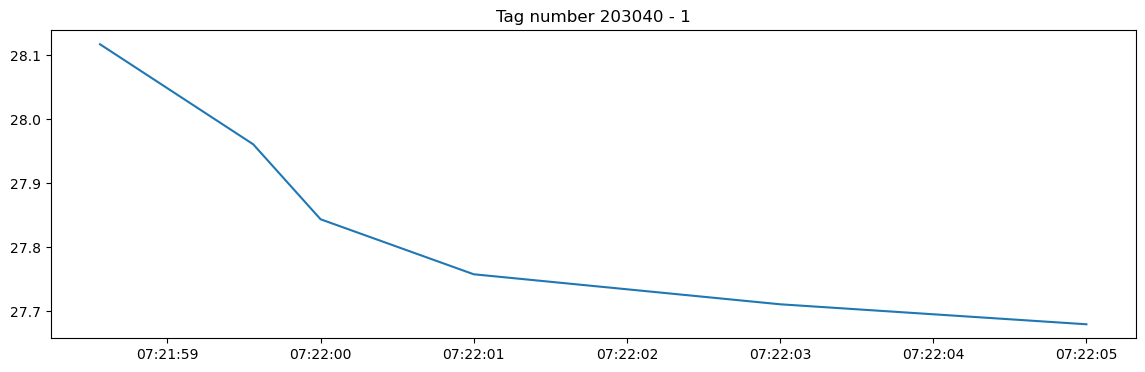

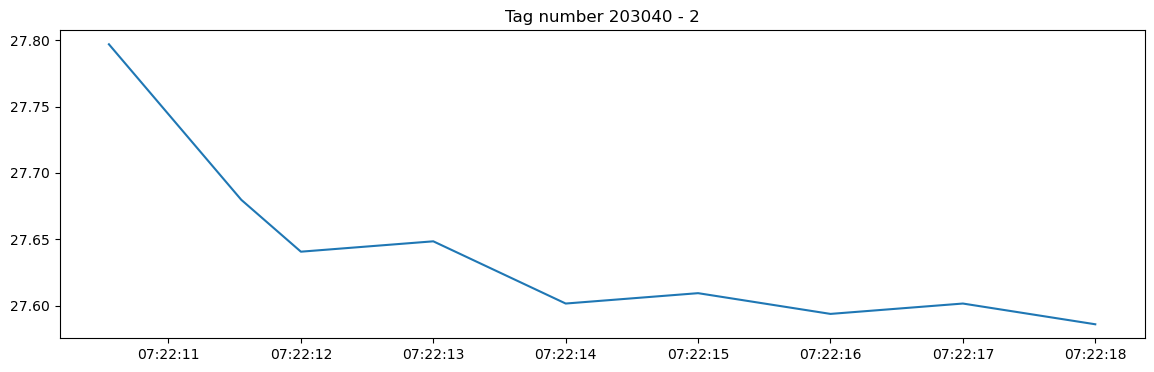

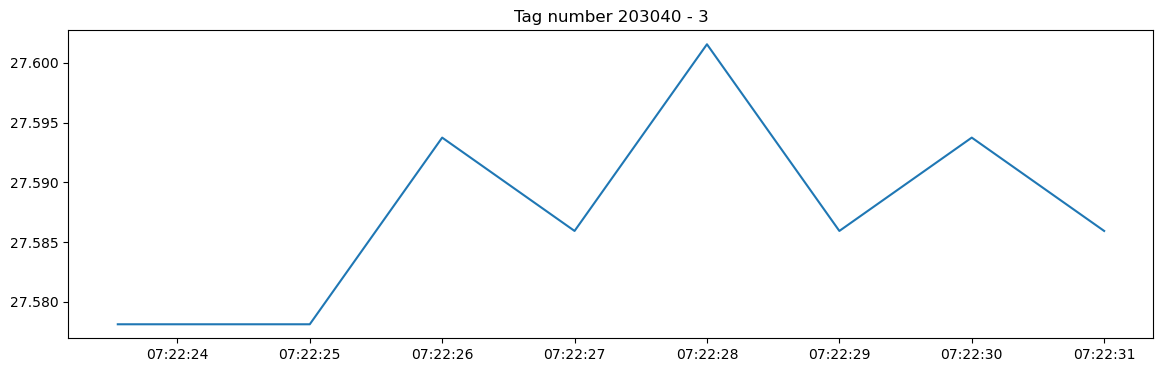

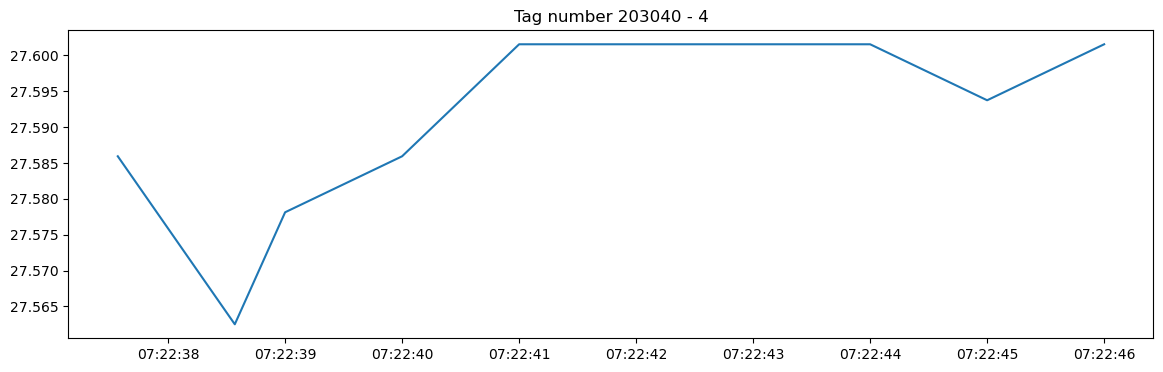

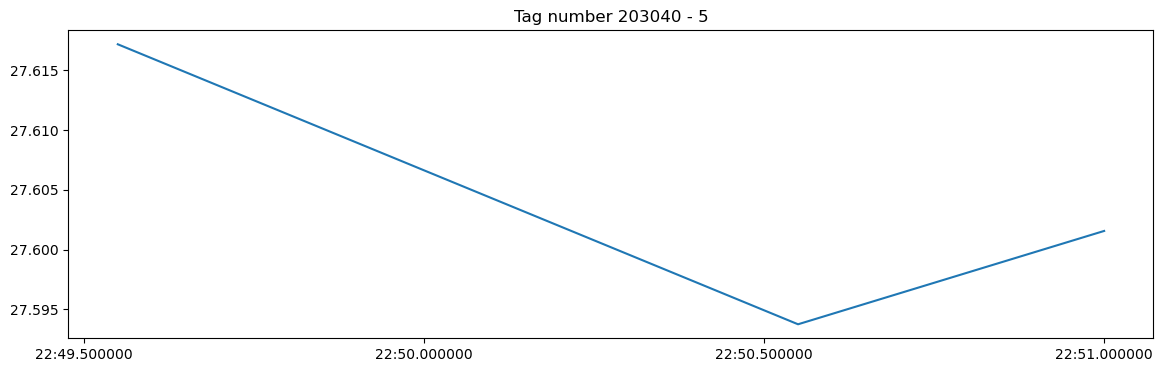

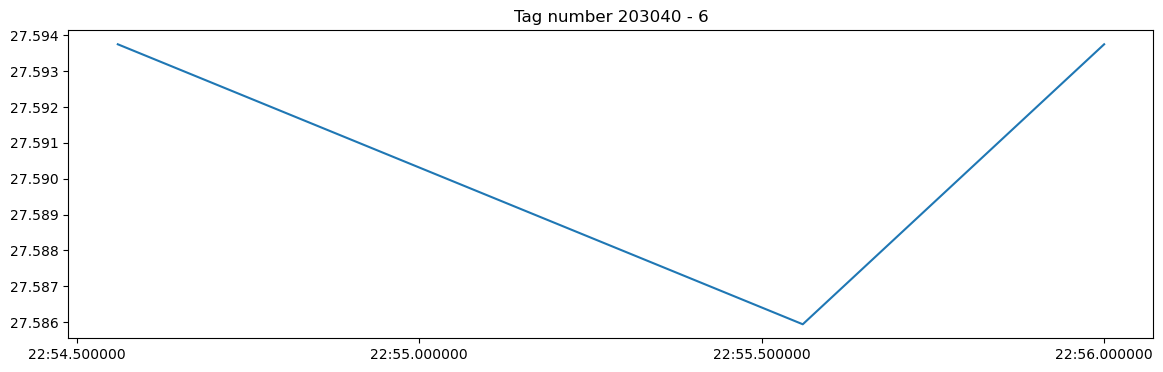

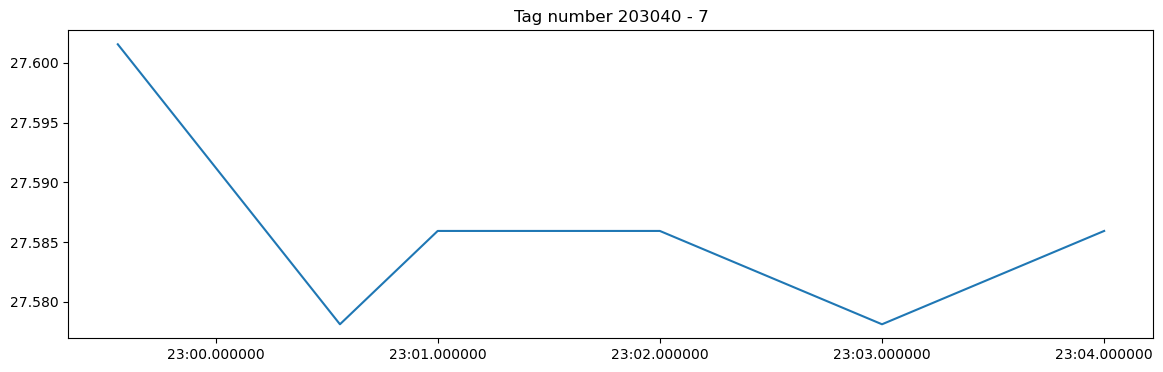

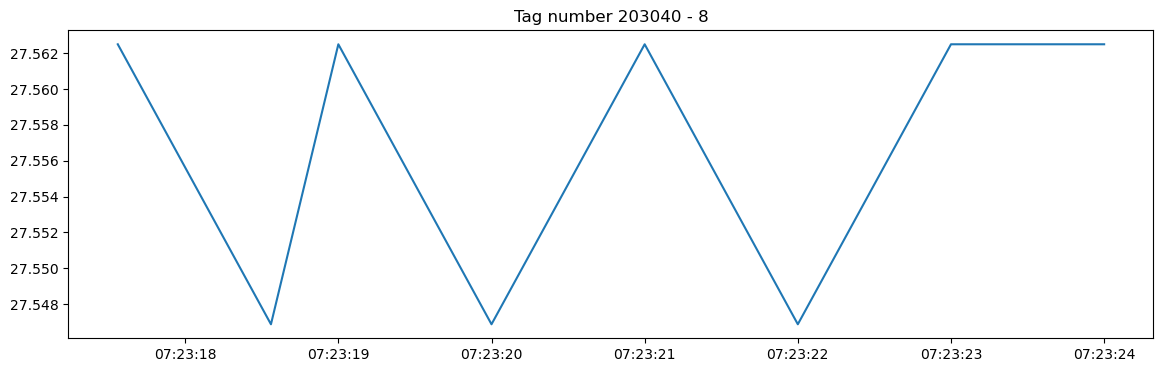

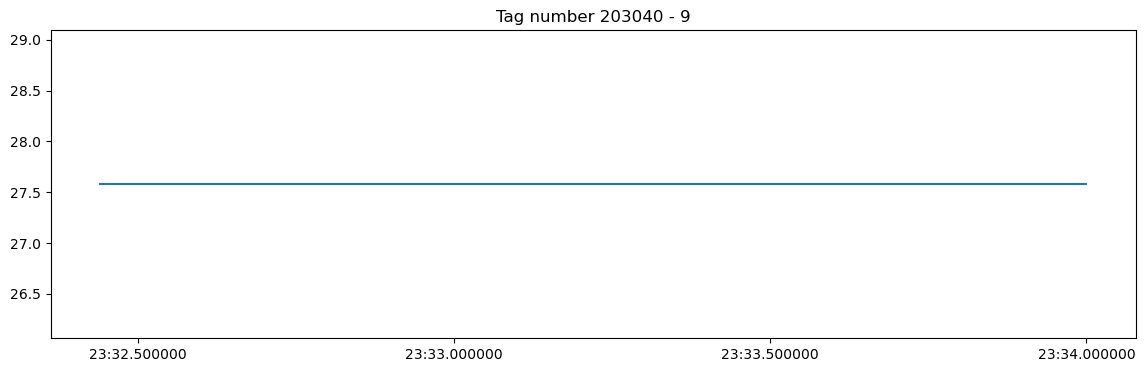

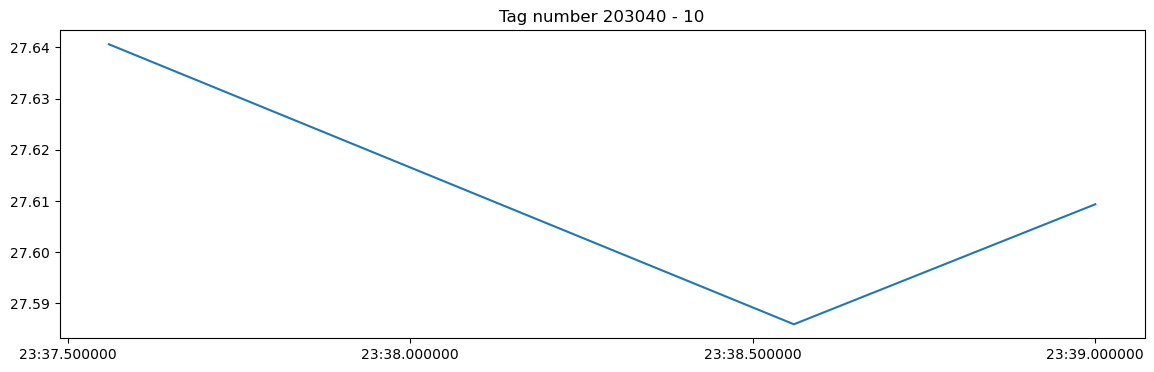

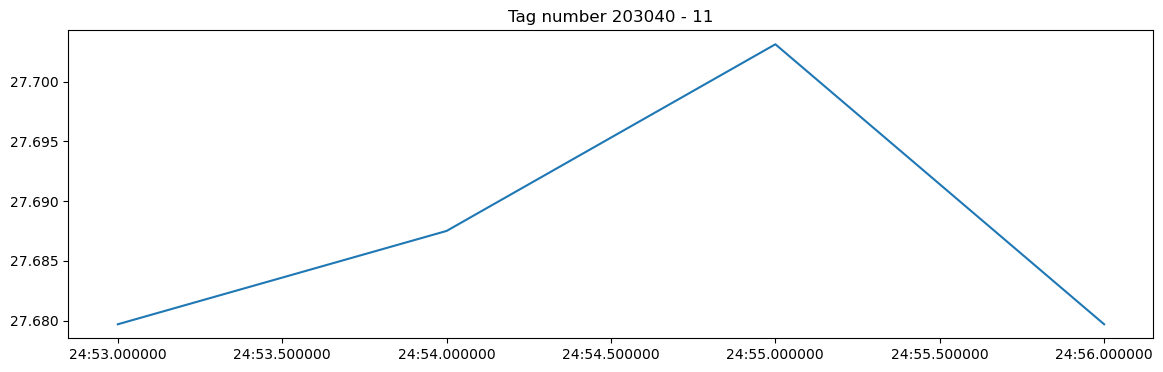

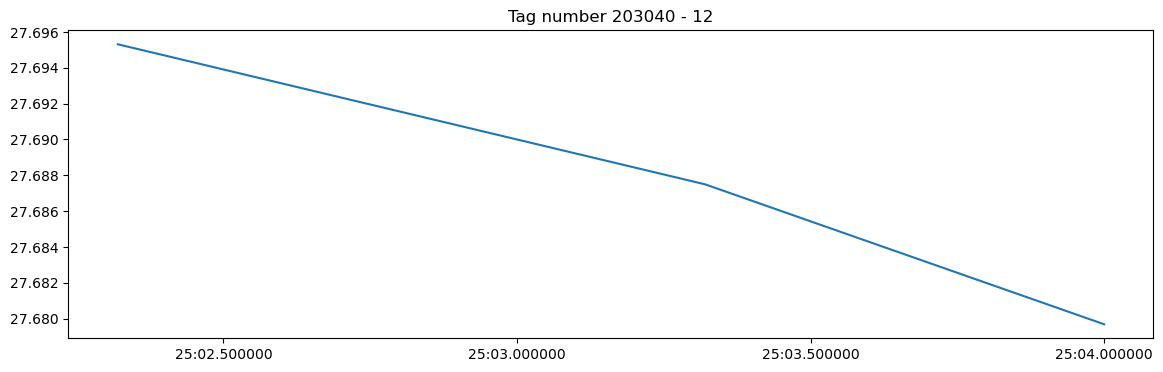

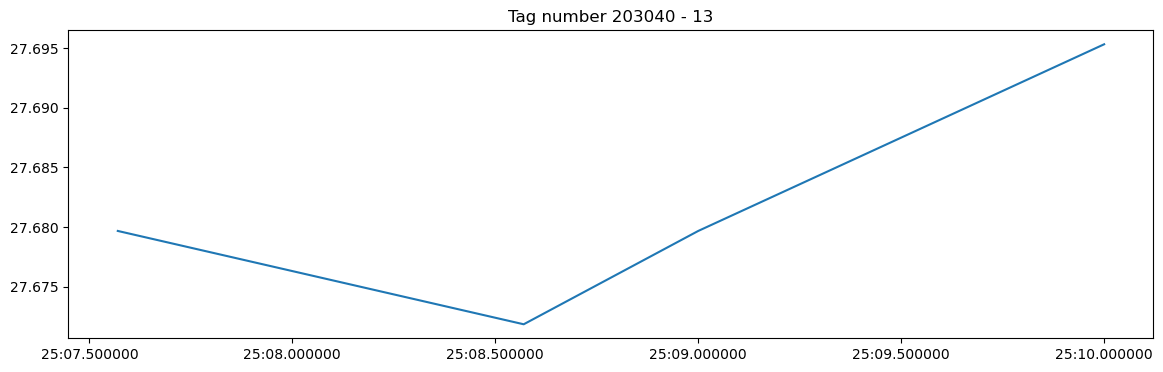

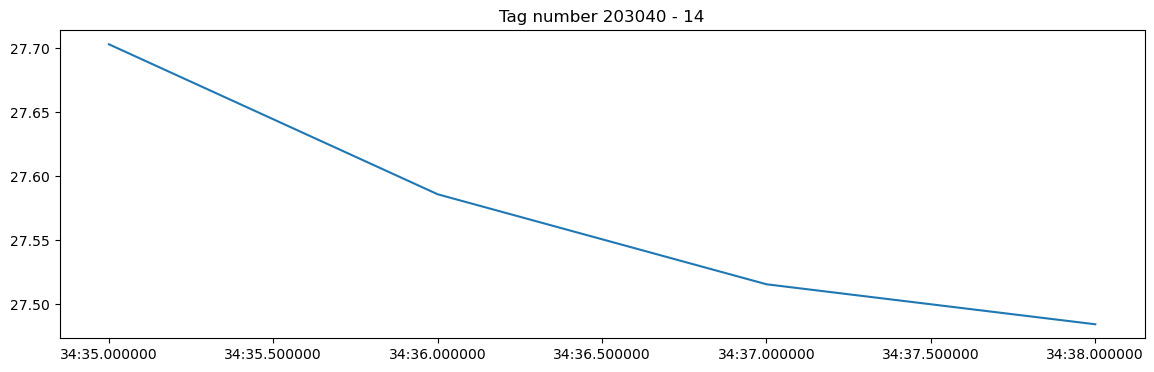

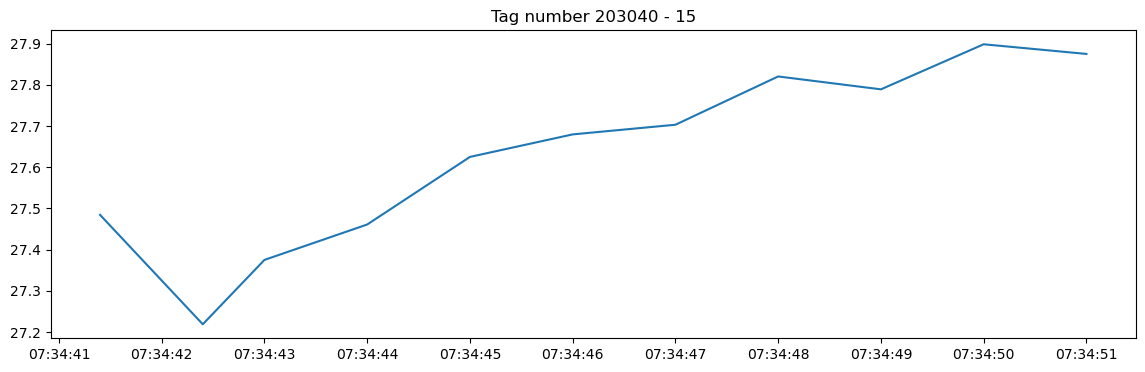

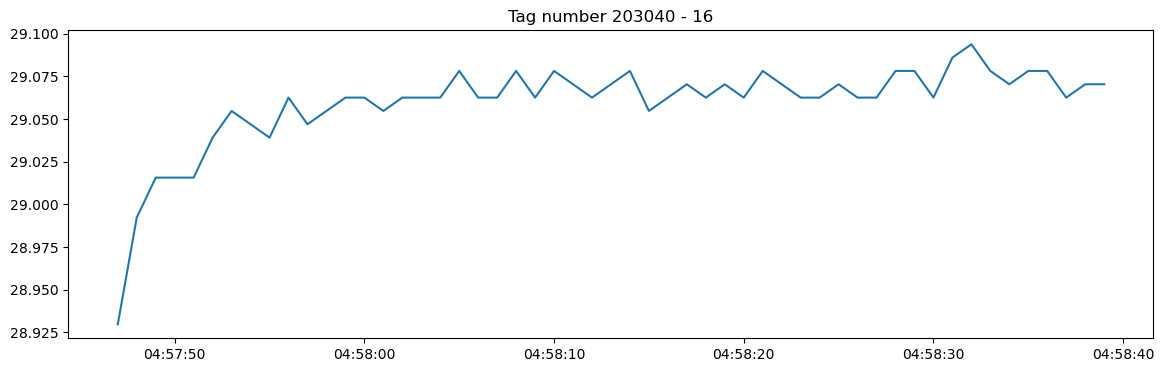

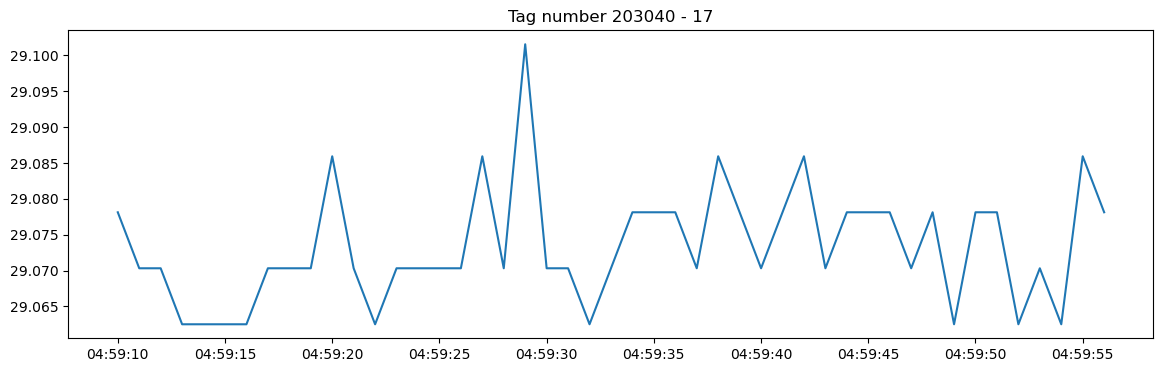

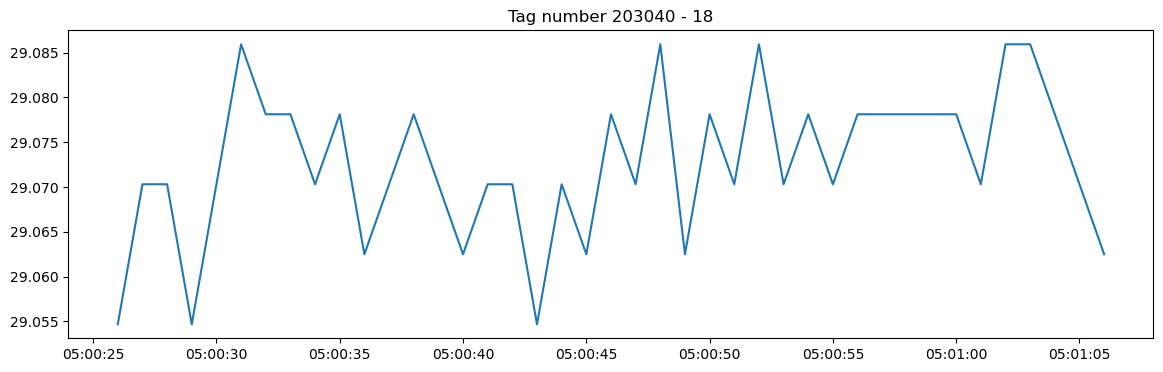

In [19]:
for ik in range(18):
    plt.figure(figsize=(14,4))
    plt.plot(ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).original_time,ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).temp)
    # plt.plot(ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).original_time,ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).depth)
    plt.title(f'Tag number {idn} - {ik+1}')
    print(np.max(np.diff(ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).time)))
    print(ds_dive_2.isel(dive_index=ik).rec_len.values)

[2.39 3.55 4.61 5.73 6.42 7.2  7.82 8.17 8.41 8.47 8.5  8.44 8.44 8.44
 8.44 8.47 8.44 8.35 8.2  8.2  8.23 8.29 8.47 8.44 8.38 8.41 8.41 8.47
 8.47 8.5  8.44 8.23 8.38 8.17 7.32 5.92 4.39 2.8  1.18 0.  ] 8.5
26.0
40
[2.42 3.67 5.05 6.11 6.88 7.6  8.13 8.2  8.47 8.35 8.17 8.47 8.53 8.5
 8.53 8.5  8.47 8.5  8.53 8.53 8.6  8.5  8.5  8.5  8.47 8.5  8.47 8.41
 8.5  8.5  8.53 8.53 8.53 8.41 8.29 8.41 8.35 8.29 8.29 8.38 8.5  8.47
 8.44 8.47 8.44 8.38 8.26 7.82 7.1  6.11 4.73 3.33 1.92 0.33] 8.6
40.0
54
[3.27 4.36 5.42 6.29 7.26 8.04 8.5  8.57 8.73 8.67 8.57 8.67 8.7  8.73
 8.73 8.7  8.7  8.7  8.7  8.7  8.63 8.67 8.67 8.7  8.73 8.67 8.7  8.76
 8.67 8.67 8.67 8.67 8.63 8.63 8.63 8.63 8.63 8.63 8.63 8.67 8.67 8.56
 8.63 8.6  8.53 8.56 8.6  8.5  8.6  8.5  8.44 8.35 7.79 6.98 5.98 4.92
 3.67 2.21 0.65] 8.76
45.0
59
[3.27 4.51 5.54 6.35 7.01 7.64 8.13 8.41 8.47 8.44 8.38 8.38 8.41 8.38
 8.44 8.38 8.35 8.35 8.35 8.32 8.35 8.41 8.29 8.35 8.41 8.35 8.41 8.38
 8.38 8.35 8.32 8.35 8.41 8.38 8.38 8.38 8

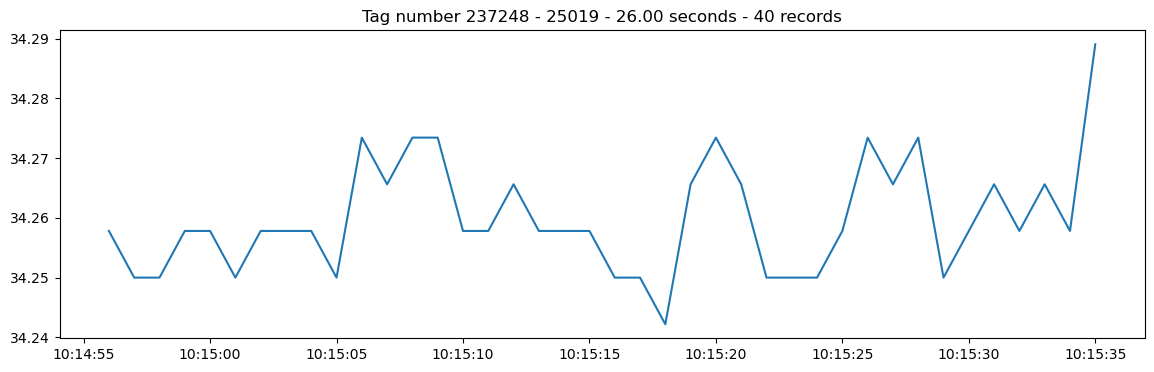

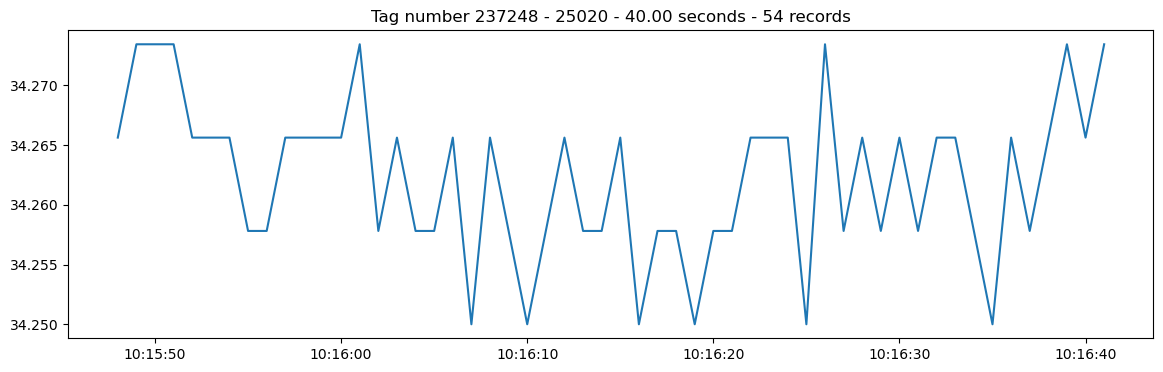

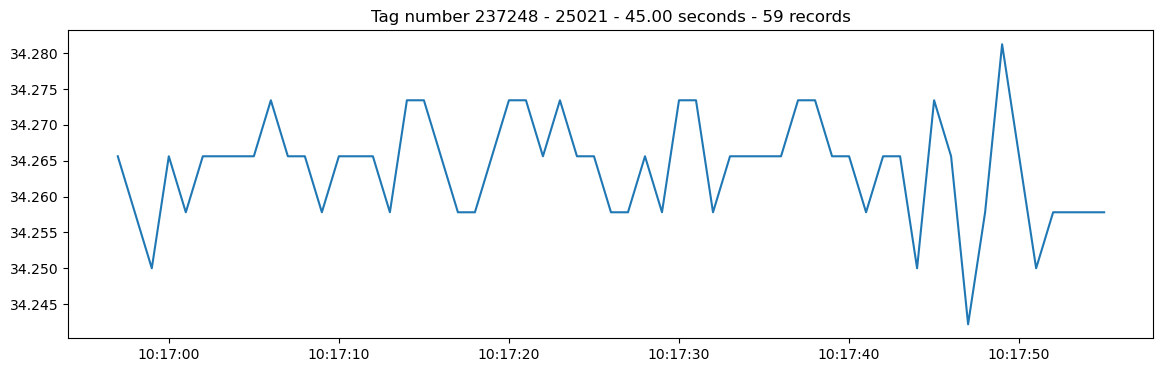

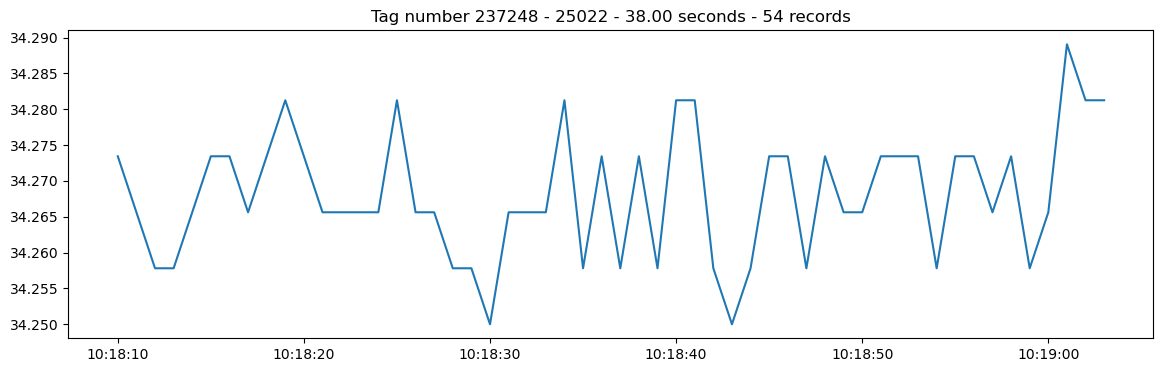

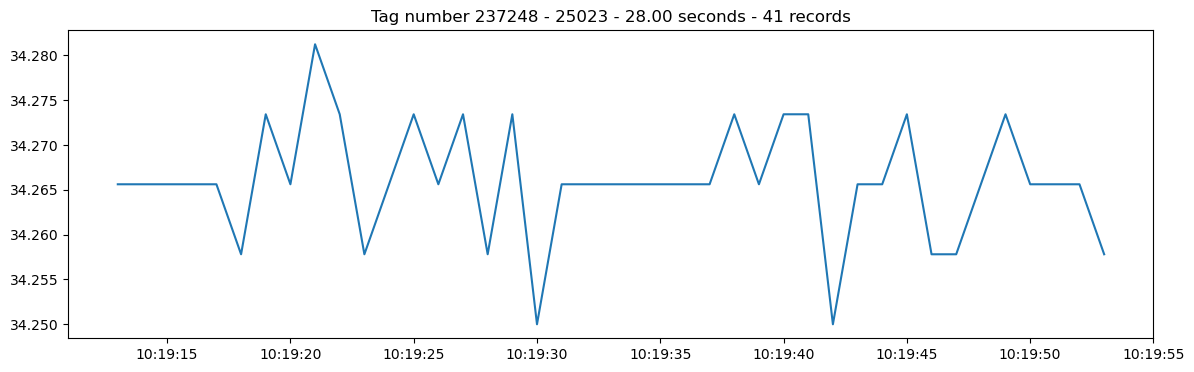

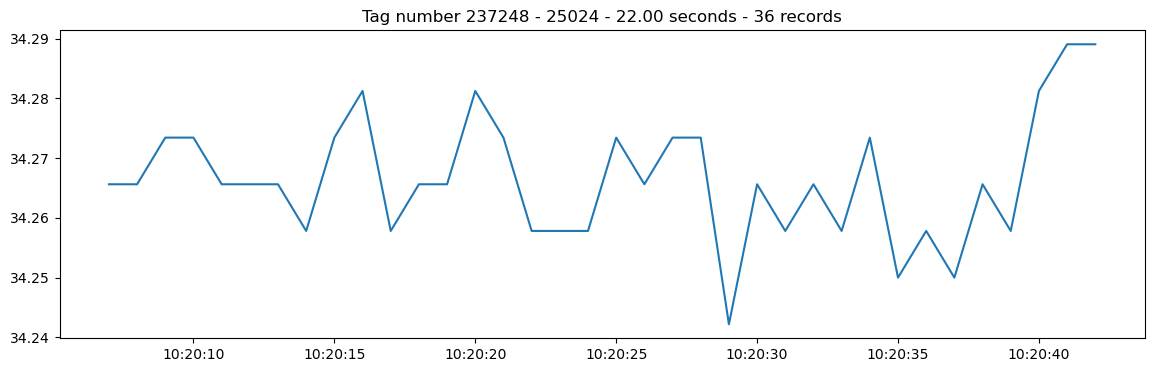

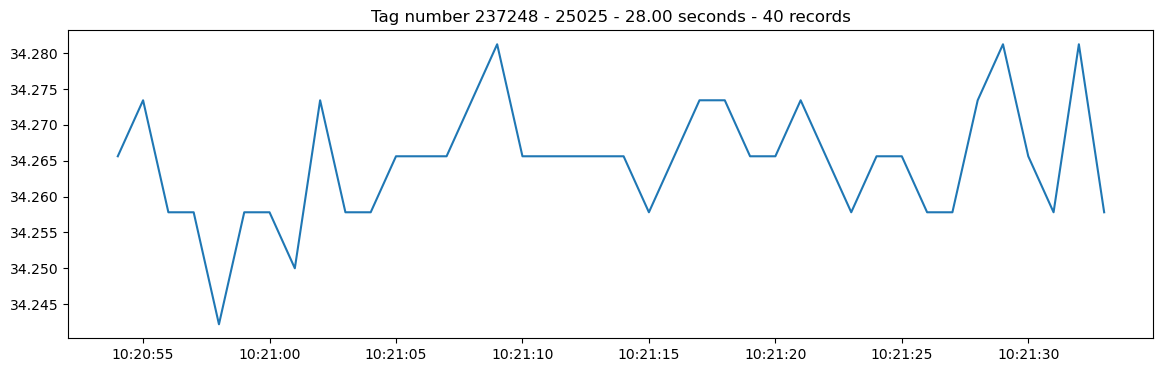

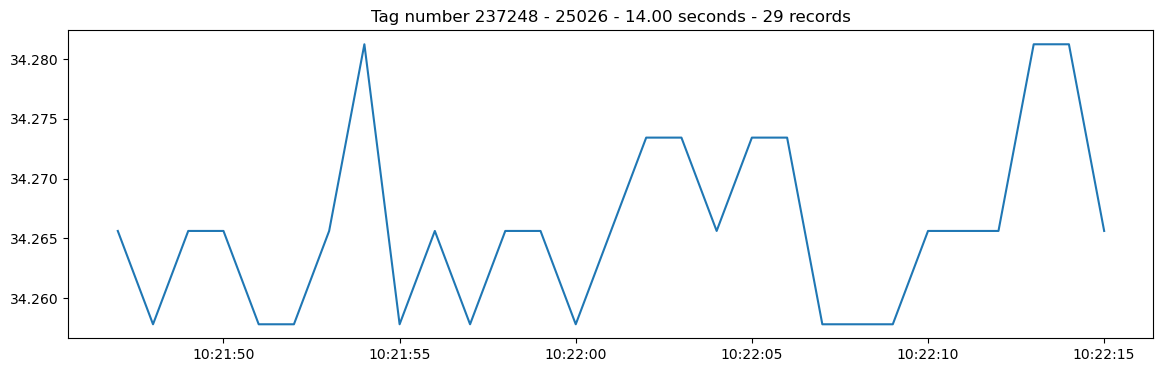

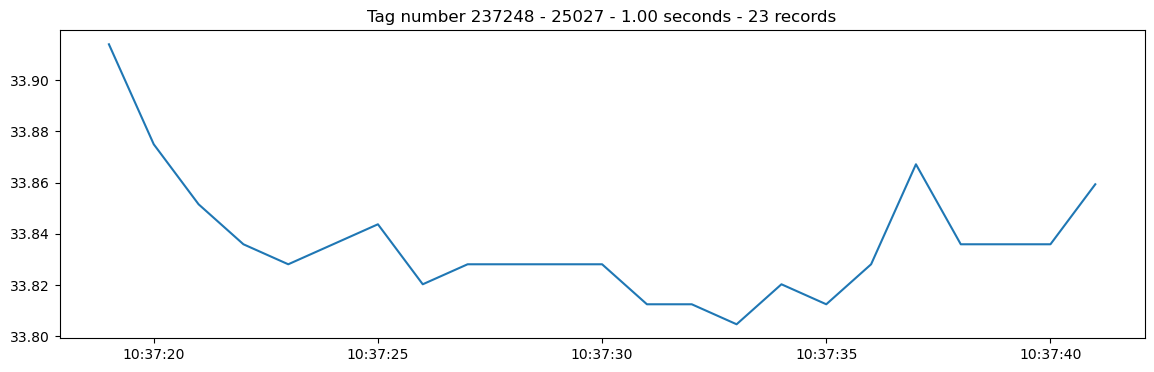

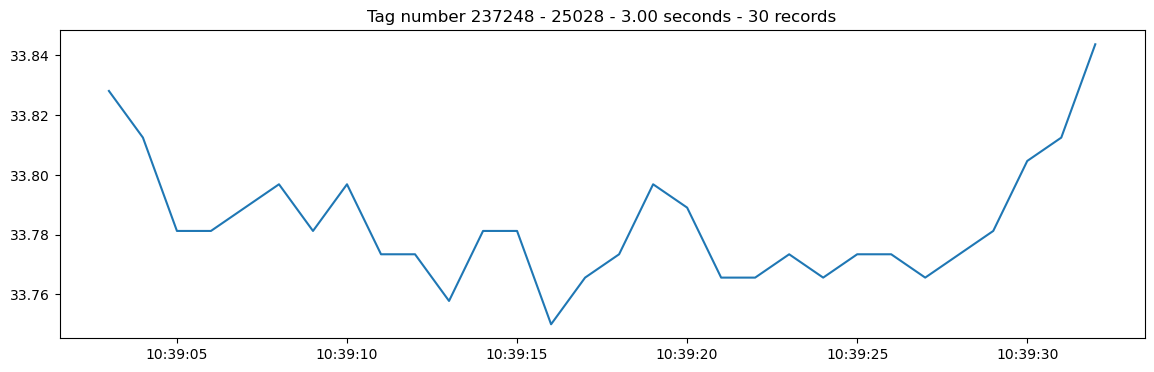

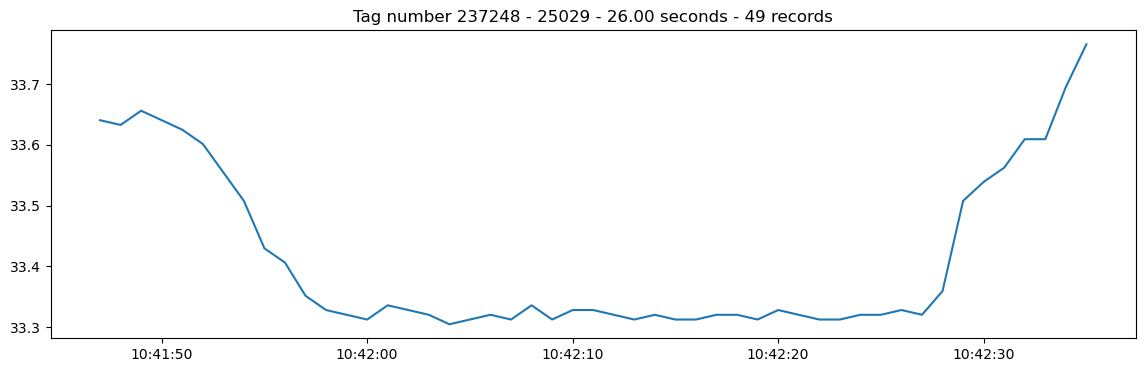

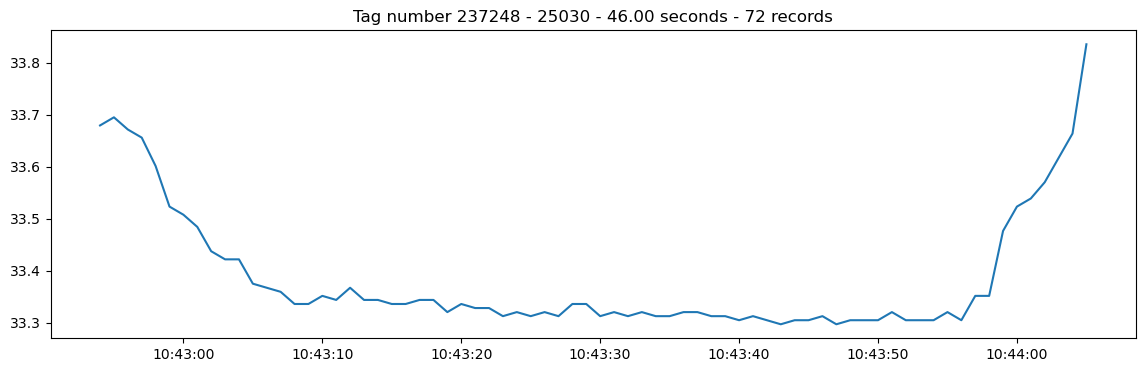

In [ ]:
# # Initialize the new variables in ds_obs_1
# ds_obs_1['first_record'] = xr.DataArray(np.full(ds_obs_1.dims['time_index'], np.nan), dims='time_index')
# ds_obs_1['last_record'] = xr.DataArray(np.full(ds_obs_1.dims['time_index'], np.nan), dims='time_index')
# ds_obs_1['dtb'] = xr.DataArray(np.full(ds_obs_1.dims['time_index'], np.nan), dims='time_index')

# for ik in range(25018,25030):
#     plt.figure(figsize=(14,4))
#     # plt.plot(ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).original_time,ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).temp)
#     profile0 = ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True)
#     dd = profile0.depth
#     dnmax = np.max(dd)
#     print(dd.values,dnmax.values)
#     nn = len(dd[dd - dnmax <= 0.5])
#     first_record = dd[abs(dd - dnmax)<=0.5].time_index.values[0]
#     last_record = dd[abs(dd - dnmax) <= 0.5].time_index.values[-1]
#     dtb = profile0.original_time.sel(time_index=last_record) - profile0.original_time.sel(time_index=first_record)
#     dtb_seconds = dtb.values/np.timedelta64(1, 's')
#     print(dtb_seconds)
#     print(nn)
#     plt.plot(ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).original_time,ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).temp)
#     plt.title(f'Tag number {idn} - {ik+1} - {dtb_seconds:.2f} seconds - {nn} records')
#     ds_obs_1['first_record'] = xr.where(ds_obs_1.mask2 == ik+1, first_record, ds_obs_1.first_record)
#     ds_obs_1['last_record'] = xr.where(ds_obs_1.mask2 == ik+1, last_record, ds_obs_1.last_record)
#     ds_obs_1['dtb'] = xr.where(ds_obs_1.mask2 == ik+1, dtb_seconds, ds_obs_1.dtb)

# 1. Find the bottom dives / max depth / duration of dives

In [77]:
# Initialize the new variables in ds_obs_1
# ds_obs_1['first_record'] = xr.DataArray(np.full(ds_obs_1.dims['time_index'], np.nan), dims='time_index')
# ds_obs_1['last_record'] = xr.DataArray(np.full(ds_obs_1.dims['time_index'], np.nan), dims='time_index')
# ds_obs_1['dtb'] = xr.DataArray(np.full(ds_obs_1.dims['time_index'], np.nan), dims='time_index')

# Create an empty pandas DataFrame to store the results
pd_dive = pd.DataFrame(columns=['ik', 'first_record', 'last_record', 'dtb', 'dmax','T_surf','T_bot'])
for ik in np.unique(ds_obs_1.mask2)[1:]:  ### omit 0_start from 1 ___
# for ik in range(30):
    if ik % 100 == 0:
        print(f'Processing mask2 value: {ik}')
    # plt.figure(figsize=(14,4))
    # plt.plot(ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).original_time,ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).temp)
    profile0 = ds_obs_1.where(ds_obs_1.mask2==ik,drop=True)
    dd = profile0.depth
    dnmax = np.max(dd).values
    # print(dd.values,dnmax.values)
    nn = len(dd[dd - dnmax <= 0.5])
    first_record = dd[abs(dd - dnmax)<=0.5].time_index.values[0]
    last_record = dd[abs(dd - dnmax) <= 0.5].time_index.values[-1]
    # dtb = (profile0.original_time.sel(time_index=last_record) - profile0.original_time.sel(time_index=first_record)).values/np.timedelta64(1, 's')
    temp_surf = profile0.temp.isel(time_index=-1).values
    temp_surf0 = profile0.temp.isel(time_index=0).values
    # temp_bot = profile0.temp.sel(time_index=last_record).values
    # print(dtb_seconds)
    # print(nn)
    # plt.plot(ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).original_time,ds_obs_1.where(ds_obs_1.mask2==ik+1,drop=True).depth)
    # plt.title(f'Tag number {idn} - {ik+1} - {dtb_seconds:.2f} seconds - {nn} records')
    # ds_obs_1['first_record'] = xr.where(ds_obs_1.mask2 == ik+1, first_record, ds_obs_1.first_record)
    # ds_obs_1['last_record'] = xr.where(ds_obs_1.mask2 == ik+1, last_record, ds_obs_1.last_record)
    # ds_obs_1['dtb'] = xr.where(ds_obs_1.mask2 == ik+1, dtb, ds_obs_1.dtb)

    # Store ik, first_record, last_record, dtb to a pandas DataFrame
    # if 'pd_dive' not in globals():
    #     pd_dive = pd.DataFrame(columns=['ik', 'first_record', 'last_record', 'dtb'])

    # pd_dive = pd.concat([pd_dive, pd.DataFrame({'ik': [ik], 'first_record': [first_record], 'last_record': [last_record], 'dtb': [dtb], 'dmax': [dnmax],'T_surf':[temp_surf],'T_bot':[temp_bot]})], ignore_index=True)
    pd_dive = pd.concat([pd_dive, pd.DataFrame({'ik': [ik], 'first_record': [first_record], 'last_record': [last_record], 'dmax': [dnmax],'T_surf':[temp_surf],'T_surf0':[temp_surf0]})], ignore_index=True)

Processing mask2 value: 100.0
Processing mask2 value: 200.0
Processing mask2 value: 300.0
Processing mask2 value: 400.0
Processing mask2 value: 500.0
Processing mask2 value: 600.0
Processing mask2 value: 700.0
Processing mask2 value: 800.0
Processing mask2 value: 900.0
Processing mask2 value: 1000.0
Processing mask2 value: 1100.0
Processing mask2 value: 1200.0
Processing mask2 value: 1300.0
Processing mask2 value: 1400.0
Processing mask2 value: 1500.0
Processing mask2 value: 1600.0
Processing mask2 value: 1700.0
Processing mask2 value: 1800.0
Processing mask2 value: 1900.0
Processing mask2 value: 2000.0
Processing mask2 value: 2100.0
Processing mask2 value: 2200.0
Processing mask2 value: 2300.0
Processing mask2 value: 2400.0
Processing mask2 value: 2500.0
Processing mask2 value: 2600.0
Processing mask2 value: 2700.0
Processing mask2 value: 2800.0
Processing mask2 value: 2900.0
Processing mask2 value: 3000.0
Processing mask2 value: 3100.0
Processing mask2 value: 3200.0
Processing mask2 

In [78]:
pd_dive['lon'] = ds_obs_1.lon_end.isel(time_index=pd_dive['last_record'].values.astype(int)).values
pd_dive['lat'] = ds_obs_1.lat_end.isel(time_index=pd_dive['last_record'].values.astype(int)).values
pd_dive['time'] = ds_obs_1.original_time.isel(time_index=pd_dive['last_record'].values.astype(int)).values
pd_dive['T_bot'] = ds_obs_1.temp.isel(time_index=pd_dive['last_record'].values.astype(int)).values

pd_dive['rec_len'] = pd_dive['last_record']-pd_dive['first_record']
pd_dive

ik first_record last_record  dtb    dmax      T_surf      T_bot  \
0          1.0           64          68  NaN    2.91  28.2109375  28.101562   
1          2.0           74          93  NaN    3.04  28.0390625  28.039062   
2          3.0           99         128  NaN    2.98  28.0390625  28.015625   
3          4.0          134         149  NaN    1.46  28.3828125  28.406250   
4          5.0          153         181  NaN    1.32  28.3671875  28.367188   
...        ...          ...         ...  ...     ...         ...        ...   
19602  19603.0       609245      609485  NaN  132.56  30.5546875  30.554688   
19603  19604.0       609486      609726  NaN  132.56   30.546875  30.546875   
19604  19605.0       609727      609967  NaN  132.56   30.359375  30.359375   
19605  19606.0       609968      610208  NaN  132.56    30.03125  30.031250   
19606  19607.0       610209      610449  NaN  132.59   29.609375  29.609375   

          T_surf0        lon        lat                time rec_len  
0      28.2578125  50.780949  25.729845 2023-11-04 06:51:35       4  
1       28.140625  50.780949  25.729845 2023-11-04 06:52:05      19  
2      28.0390625  50.780411  25.730028 2023-11-04 06:52:49      29  
3       28.359375  50.781914  25.724712 2023-11-04 06:54:27      15  
4        28.34375  50.781803  25.724785 2023-11-04 06:55:54      28  
...           ...        ...        ...                 ...     ...  
19602    30.28125  50.417881  25.488762 2024-04-26 14:32:49     240  
19603    30.59375  50.417881  25.488762 2024-04-26 14:40:51     240  
19604    30.46875  50.417881  25.488762 2024-04-26 14:48:55     240  
19605    30.21875  50.417881  25.488762 2024-04-26 14:56:59     240  
19606  29.7578125  50.417881  25.488762 2024-04-26 15:05:03     240  

[19607 rows x 12 columns]

ik first_record last_record  dtb    dmax      T_surf      T_bot  \
0          1.0           64          68  NaN    2.91  28.2109375  28.101562   
1          2.0           74          93  NaN    3.04  28.0390625  28.039062   
2          3.0           99         128  NaN    2.98  28.0390625  28.015625   
3          4.0          134         149  NaN    1.46  28.3828125  28.406250   
4          5.0          153         181  NaN    1.32  28.3671875  28.367188   
...        ...          ...         ...  ...     ...         ...        ...   
19602  19603.0       609245      609485  NaN  132.56  30.5546875  30.554688   
19603  19604.0       609486      609726  NaN  132.56   30.546875  30.546875   
19604  19605.0       609727      609967  NaN  132.56   30.359375  30.359375   
19605  19606.0       609968      610208  NaN  132.56    30.03125  30.031250   
19606  19607.0       610209      610449  NaN  132.59   29.609375  29.609375   

             lon        lat                time  
0      50.780949  25.729845 2023-11-04 06:51:35  
1      50.780949  25.729845 2023-11-04 06:52:05  
2      50.780411  25.730028 2023-11-04 06:52:49  
3      50.781914  25.724712 2023-11-04 06:54:27  
4      50.781803  25.724785 2023-11-04 06:55:54  
...          ...        ...                 ...  
19602  50.417881  25.488762 2024-04-26 14:32:49  
19603  50.417881  25.488762 2024-04-26 14:40:51  
19604  50.417881  25.488762 2024-04-26 14:48:55  
19605  50.417881  25.488762 2024-04-26 14:56:59  
19606  50.417881  25.488762 2024-04-26 15:05:03  

[19607 rows x 10 columns]

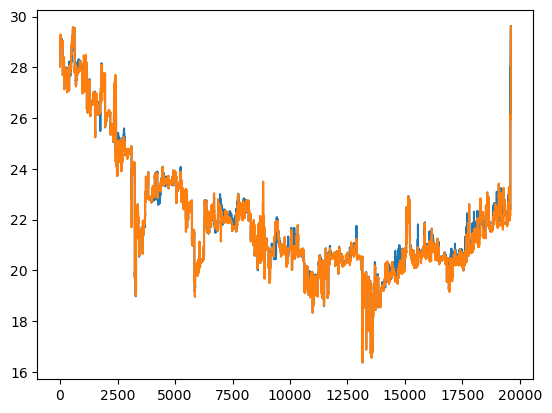

In [55]:
pd_dive[pd_dive['T_surf']<30].T_surf.astype(float).plot()
pd_dive[pd_dive['T_surf']<30].T_bot.astype(float).plot()
pd_dive

<Axes: >

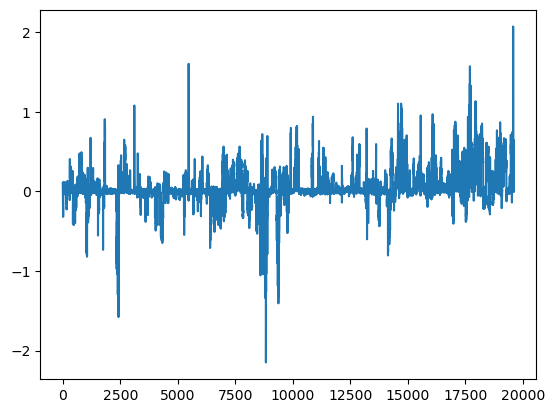

In [104]:
# pd_dive[pd_dive['T_surf']<50].T_surf.astype(float).plot()
(pd_dive[pd_dive['T_surf']<50].T_surf-pd_dive[pd_dive['T_surf']<50].T_bot).astype(float).plot()

In [105]:
pd_dive.to_csv(wrk_dir+'dive_profile_PG_acc_raw_v1_keep_gps_BAHHASO23.csv')

In [106]:
pd_dive = pd.read_csv('dive_profile_PG_acc_raw_v1_keep_gps_BAHHASO23.csv',parse_dates=True,index_col='time')
pd_dive

Unnamed: 0       ik  first_record  last_record  dtb  \
time                                                                       
2023-11-04 06:51:35           0      1.0            64           68  NaN   
2023-11-04 06:52:05           1      2.0            74           93  NaN   
2023-11-04 06:52:49           2      3.0            99          128  NaN   
2023-11-04 06:54:27           3      4.0           134          149  NaN   
2023-11-04 06:55:54           4      5.0           153          181  NaN   
...                         ...      ...           ...          ...  ...   
2024-04-26 14:32:49       19602  19603.0        609245       609485  NaN   
2024-04-26 14:40:51       19603  19604.0        609486       609726  NaN   
2024-04-26 14:48:55       19604  19605.0        609727       609967  NaN   
2024-04-26 14:56:59       19605  19606.0        609968       610208  NaN   
2024-04-26 15:05:03       19606  19607.0        610209       610449  NaN   

                       dmax     T_surf      T_bot    T_surf0        lon  \
time                                                                      
2023-11-04 06:51:35    2.91  28.210938  28.101562  28.257812  50.780949   
2023-11-04 06:52:05    3.04  28.039062  28.039062  28.140625  50.780949   
2023-11-04 06:52:49    2.98  28.039062  28.015625  28.039062  50.780411   
2023-11-04 06:54:27    1.46  28.382812  28.406250  28.359375  50.781914   
2023-11-04 06:55:54    1.32  28.367188  28.367188  28.343750  50.781803   
...                     ...        ...        ...        ...        ...   
2024-04-26 14:32:49  132.56  30.554688  30.554688  30.281250  50.417881   
2024-04-26 14:40:51  132.56  30.546875  30.546875  30.593750  50.417881   
2024-04-26 14:48:55  132.56  30.359375  30.359375  30.468750  50.417881   
2024-04-26 14:56:59  132.56  30.031250  30.031250  30.218750  50.417881   
2024-04-26 15:05:03  132.59  29.609375  29.609375  29.757812  50.417881   

                           lat  rec_len  
time                                     
2023-11-04 06:51:35  25.729845        4  
2023-11-04 06:52:05  25.729845       19  
2023-11-04 06:52:49  25.730028       29  
2023-11-04 06:54:27  25.724712       15  
2023-11-04 06:55:54  25.724785       28  
...                        ...      ...  
2024-04-26 14:32:49  25.488762      240  
2024-04-26 14:40:51  25.488762      240  
2024-04-26 14:48:55  25.488762      240  
2024-04-26 14:56:59  25.488762      240  
2024-04-26 15:05:03  25.488762      240  

[19607 rows x 12 columns]

In [107]:
ds_dive = xr.Dataset.from_dataframe(pd_dive)
ds_dive

<xarray.Dataset>
Dimensions:       (time: 19607)
Coordinates:
  * time          (time) datetime64[ns] 2023-11-04T06:51:35 ... 2024-04-26T15...
Data variables:
    Unnamed: 0    (time) int64 0 1 2 3 4 5 ... 19602 19603 19604 19605 19606
    ik            (time) float64 1.0 2.0 3.0 ... 1.96e+04 1.961e+04 1.961e+04
    first_record  (time) int64 64 74 99 134 153 ... 609486 609727 609968 610209
    last_record   (time) int64 68 93 128 149 181 ... 609726 609967 610208 610449
    dtb           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dmax          (time) float64 2.91 3.04 2.98 1.46 ... 132.6 132.6 132.6 132.6
    T_surf        (time) float64 28.21 28.04 28.04 28.38 ... 30.36 30.03 29.61
    T_bot         (time) float64 28.1 28.04 28.02 28.41 ... 30.36 30.03 29.61
    T_surf0       (time) float64 28.26 28.14 28.04 28.36 ... 30.47 30.22 29.76
    lon           (time) float64 50.78 50.78 50.78 50.78 ... 50.42 50.42 50.42
    lat           (time) float64 25.73 25.73 25.73 25.72 ... 25.49 25.49 25.49
    rec_len       (time) int64 4 19 29 15 28 22 14 ... 240 240 240 240 240 240

In [22]:
ds_mur_sec1=ds_mur.sst.sel(time=slice(ds_dive_2.time.min(),ds_dive_2.time.max()),lon=slice(47,58),lat=slice(22,33))


In [23]:
# UAE 2020
# ds_obs1_rnan = ds_obs1.where((ds_obs1.x>10)&(ds_obs1.y>10)&(ds_obs1.temp<40)&(ds_obs1.temp>10)&(ds_obs1.temp!=31.2421875),drop=True)

# ds_mur_sec1=ds_mur.sst.sel(time=slice(pd_dive.time.min(),pd_dive.time.max()))

fmm1=ds_mur_sec1.interp(lon=ds_dive.lon,lat=ds_dive.lat,time=ds_dive.time) #original

NameError: name 'ds_dive' is not defined

In [259]:
# plot ALL THE DATA (((BEFORE interpolation)))
# ds_obs1_rnan.temp.plot()
# (fmm-273.15).plot()
plt.scatter(fmm1, ds_dive.T_surf, c=ds_dive.T_surf - ds_dive.T_bot, cmap='RdYlBu', s=0.5,vmax=1,vmin=-1)
# plt.scatter(fmm1, ds_dive.T_surf, c=ds_dive.last_record - ds_dive.first_record, cmap='RdBu', s=1)

plt.colorbar(label='T_surf - T_bot')
# plt.colorbar(label='record length (seconds)')



plt.xlim([18, 30]),plt.ylim([18, 30])
plt.plot([18,37],[18,37])

# print(np.sqrt(np.mean(fmm-ds_obs_rnan1.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan2.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan3.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan4.temp)**2).values)

NameError: name 'fmm1' is not defined

In [104]:
# plot ALL THE DATA (((BEFORE interpolation)))
# ds_obs1_rnan.temp.plot()
# (fmm-273.15).plot()
# plt.scatter(fmm1, ds_dive.T_surf, c=ds_dive.T_surf - ds_dive.T_bot, cmap='RdBu', s=0.5,vmax=1,vmin=-1)
plt.figure(figsize=(8,6))
plt.scatter(fmm1, ds_dive.T_surf, c=ds_dive.last_record - ds_dive.first_record, cmap='Reds', s=2,vmax=50)
# plt.scatter(fmm1, ds_dive.where(ds_dive.rec_len<30).T_surf, cmap='RdBu', s=2,vmax=50)
# plt.scatter(fmm1, ds_dive.where(ds_dive.rec_len>30).T_surf, cmap='RdBu', s=2,vmax=50)

# plt.colorbar(label='T_surf - T_bot')
plt.colorbar(label='record length (seconds)')

plt.xlim([18, 30]),plt.ylim([18, 30])
plt.plot([18,37],[18,37])

# print(np.sqrt(np.mean(fmm-ds_obs_rnan1.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan2.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan3.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan4.temp)**2).values)

NameError: name 'fmm1' is not defined

<Figure size 800x600 with 0 Axes>

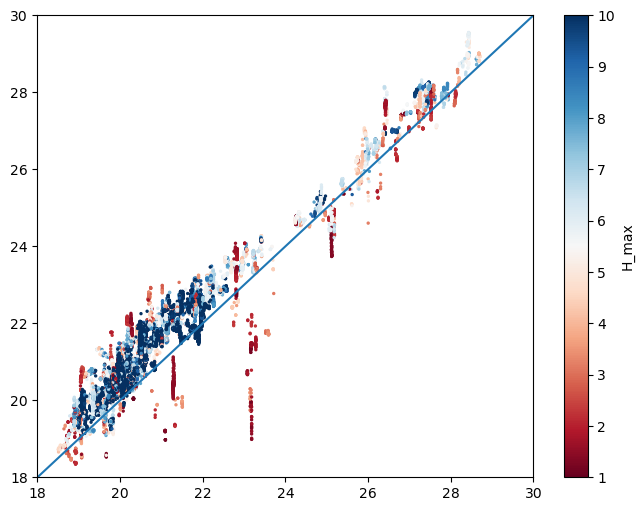

In [74]:
plt.figure(figsize=(8,6))
# plt.scatter(fmm1, ds_dive.T_surf, c=ds_dive.last_record - ds_dive.first_record, cmap='RdBu', s=2,vmax=50)
plt.scatter(fmm1, ds_dive.T_surf, c=ds_dive.dmax, cmap='RdBu', s=2,vmax=10)
# plt.scatter(fmm1, ds_dive.where(ds_dive.rec_len>30).T_surf, cmap='RdBu', s=2,vmax=50)

plt.colorbar(label='H_max (m)')
# plt.colorbar(label='record length (seconds)')

plt.xlim([18, 30]),plt.ylim([18, 30])
plt.plot([18,37],[18,37])

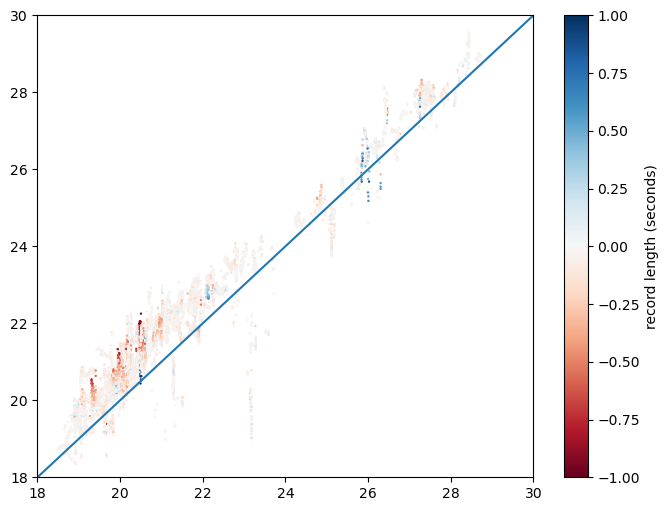

In [ ]:
# plot ALL THE DATA (((BEFORE interpolation)))
# ds_obs1_rnan.temp.plot()
# (fmm-273.15).plot()
plt.figure(figsize=(8,6))
plt.scatter(fmm1, ds_dive.T_surf, c=ds_dive.T_surf0 - ds_dive.T_surf, cmap='RdBu', s=0.5,vmax=1,vmin=-1)
# plt.scatter(fmm1, ds_dive.T_surf, c=(ds_dive.T_surf0 - ds_dive.T_surf)/np.exp(ds_dive.rec_len.astype(float)), cmap='RdBu',vmax=0.001,vmin=-0.001,s=1)
# plt.scatter(fmm1, ds_dive.where(ds_dive.rec_len<30).T_surf, cmap='RdBu', s=2,vmax=50)
# plt.scatter(fmm1, ds_dive.where(ds_dive.rec_len>30).T_surf, cmap='RdBu', s=2,vmax=50)

# plt.colorbar(label='T_surf - T_bot')
plt.colorbar(label='record length (seconds)')

plt.xlim([18, 30]),plt.ylim([18, 30])
plt.plot([18,37],[18,37])

# print(np.sqrt(np.mean(fmm-ds_obs_rnan1.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan2.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan3.temp)**2).values)
# print(np.sqrt(np.mean(fmm-ds_obs_rnan4.temp)**2).values)

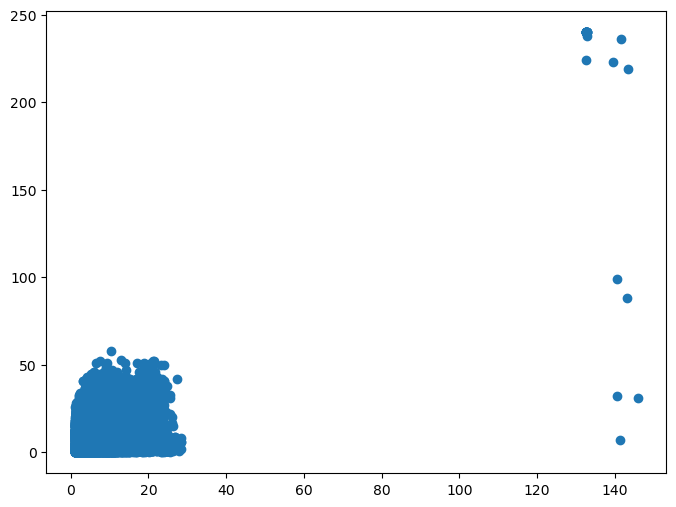

In [96]:

plt.figure(figsize=(8,6))
plt.scatter( ds_dive.dmax,ds_dive.rec_len)

# 2. Find first record and last record for each dive / duration of dives

In [20]:
ds_dive_2

<xarray.Dataset>
Dimensions:       (dive_index: 62445)
Coordinates:
  * dive_index    (dive_index) float64 0.0 1.0 2.0 3.0 ... 972.0 973.0 974.0
Data variables:
    tag_id        (dive_index) float64 2.014e+05 2.014e+05 ... 2.03e+05 2.03e+05
    temp1         (dive_index) float64 29.1 29.07 29.08 29.05 ... -1.0 -1.0 -1.0
    temp0         (dive_index) float64 29.02 29.15 29.06 ... -1.0 -1.0 -1.0
    rec_len       (dive_index) float64 39.0 52.0 36.0 39.0 ... 13.0 12.0 12.0
    first_record  (dive_index) float64 5.509e+04 5.514e+04 ... 6.266e+04
    last_record   (dive_index) float64 5.513e+04 5.519e+04 ... 6.267e+04
    lon           (dive_index) float64 53.15 53.15 53.15 ... 52.95 52.95 52.95
    lat           (dive_index) float64 24.68 24.68 24.68 ... 24.53 24.53 24.53
    time          (dive_index) datetime64[ns] 2020-11-14T06:28:34 ... 2020-12...

## do filter / Quality control

### tag 203018 close to the powerplant

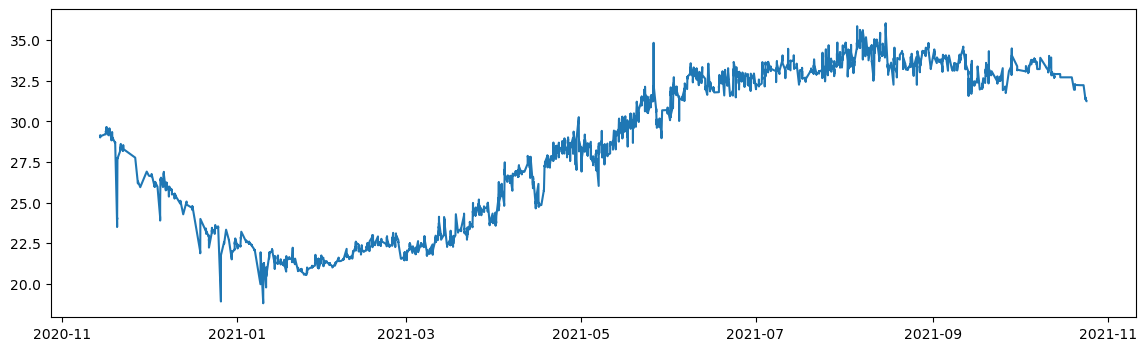

In [82]:
plt.figure(figsize=(14,4))
plt.plot(ds_dive_2.time,ds_dive_2.where((ds_dive_2.tag_id==203018)&(ds_dive_2.time<pd.Timestamp(2021,10,25))).temp1)

# plt.xlim([pd.Timestamp(2021,10,20),pd.Timestamp(2021,11,22)])


In [ ]:
ds_dive_2_filtered = ds_dive_2.where(~((ds_dive_2.tag_id == 203018) & (ds_dive_2.time > pd.Timestamp(2021, 10, 25))), drop=True)
ds_dive_2_filtered

<xarray.Dataset>
Dimensions:       (dive_index: 58577)
Coordinates:
  * dive_index    (dive_index) float64 0.0 1.0 2.0 3.0 ... 972.0 973.0 974.0
Data variables:
    tag_id        (dive_index) float64 2.014e+05 2.014e+05 ... 2.03e+05 2.03e+05
    temp1         (dive_index) float64 29.1 29.07 29.08 29.05 ... -1.0 -1.0 -1.0
    temp0         (dive_index) float64 29.02 29.15 29.06 ... -1.0 -1.0 -1.0
    rec_len       (dive_index) float64 39.0 52.0 36.0 39.0 ... 13.0 12.0 12.0
    first_record  (dive_index) float64 5.509e+04 5.514e+04 ... 6.266e+04
    last_record   (dive_index) float64 5.513e+04 5.519e+04 ... 6.267e+04
    lon           (dive_index) float64 53.15 53.15 53.15 ... 52.95 52.95 52.95
    lat           (dive_index) float64 24.68 24.68 24.68 ... 24.53 24.53 24.53
    time          (dive_index) datetime64[ns] 2020-11-14T06:28:34 ... 2020-12...

### ds_dive_2.tag_id==201410

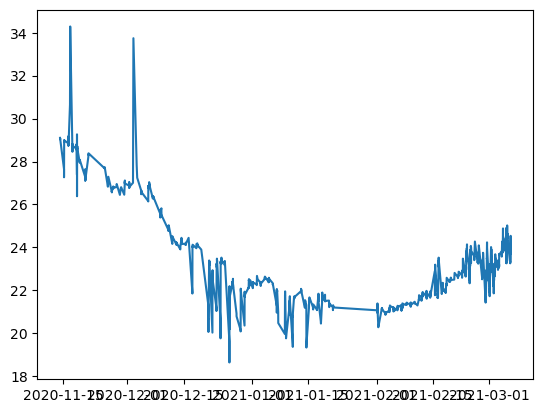

In [86]:
plt.plot(ds_dive_2.time,ds_dive_2.where(((ds_dive_2.tag_id==201410))& (ds_dive_2.time < pd.Timestamp(2021, 3, 25))).temp1)

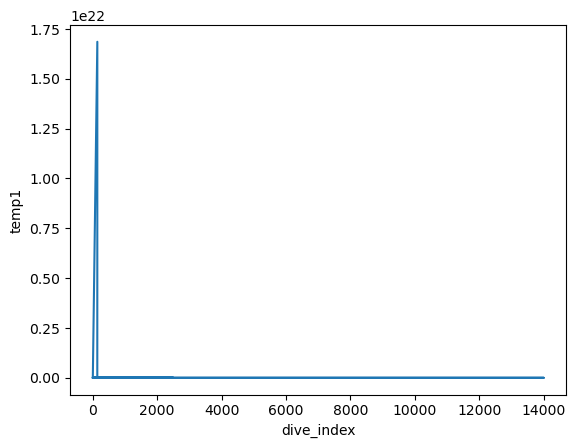

In [87]:
ds_dive_2_filtered = ds_dive_2_filtered.where(~((ds_dive_2_filtered.tag_id == 201410) & (ds_dive_2_filtered.time > pd.Timestamp(2021, 3, 25))), drop=True)
ds_dive_2_filtered.temp1.plot()

### ID = 203029

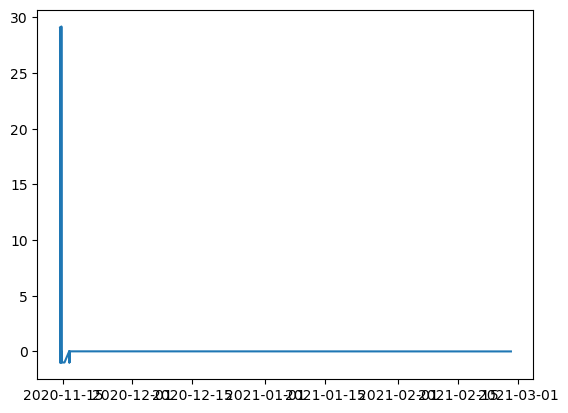

In [111]:
plt.plot(ds_dive_2.time,ds_dive_2.where(((ds_dive_2.tag_id==203029))& (ds_dive_2.time < pd.Timestamp(2021,4, 1))).temp1)

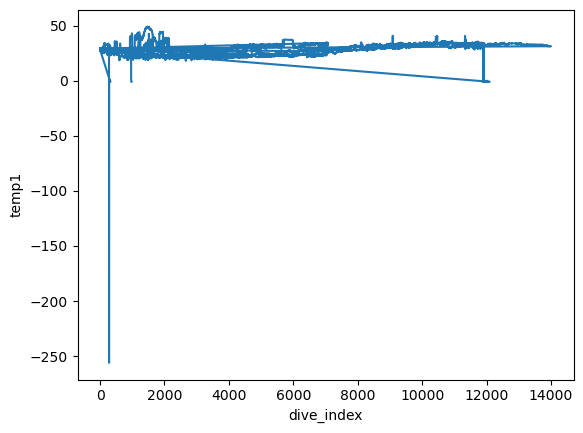

In [112]:
ds_dive_2_filtered = ds_dive_2_filtered.where(~((ds_dive_2_filtered.tag_id == 203029) ), drop=True)
ds_dive_2_filtered.temp1.plot()

### id = 201418

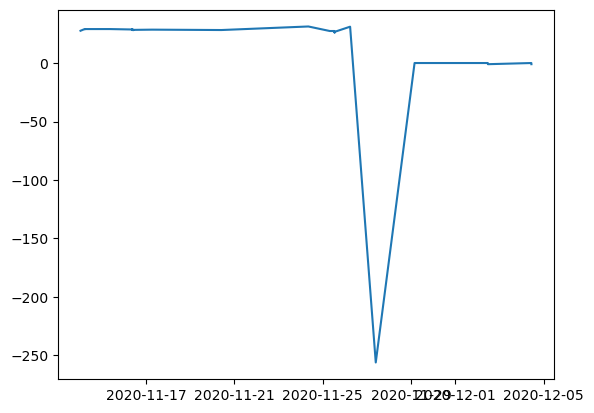

In [116]:
plt.plot(ds_dive_2.time,ds_dive_2.where(((ds_dive_2.tag_id==201418))& (ds_dive_2.time < pd.Timestamp(2025,4, 1))).temp1)

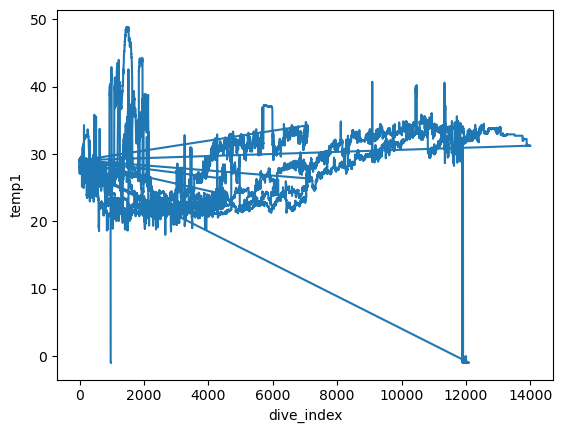

In [117]:
ds_dive_2_filtered = ds_dive_2_filtered.where(~((ds_dive_2_filtered.tag_id == 201418) ), drop=True)
ds_dive_2_filtered.temp1.plot()

### ID = 201411 && 203034 && 203040

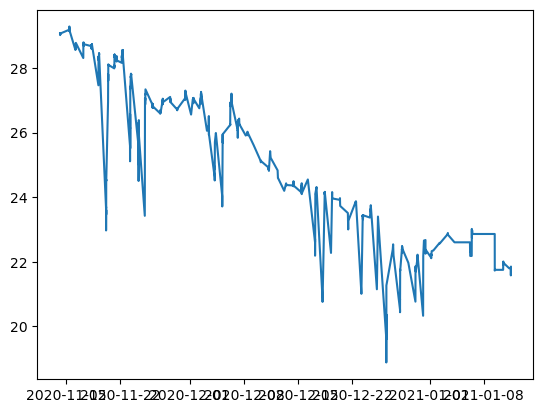

In [160]:
plt.plot(ds_dive_2.time,ds_dive_2.where(((ds_dive_2.tag_id==203034))).temp1)

In [161]:
ds_dive_2.where(((ds_dive_2.tag_id==203034)))

<xarray.Dataset>
Dimensions:       (dive_index: 62445)
Coordinates:
  * dive_index    (dive_index) float64 0.0 1.0 2.0 3.0 ... 972.0 973.0 974.0
Data variables:
    tag_id        (dive_index) float64 nan nan nan nan nan ... nan nan nan nan
    temp1         (dive_index) float64 nan nan nan nan nan ... nan nan nan nan
    temp0         (dive_index) float64 nan nan nan nan nan ... nan nan nan nan
    rec_len       (dive_index) float64 nan nan nan nan nan ... nan nan nan nan
    first_record  (dive_index) float64 nan nan nan nan nan ... nan nan nan nan
    last_record   (dive_index) float64 nan nan nan nan nan ... nan nan nan nan
    lon           (dive_index) float64 nan nan nan nan nan ... nan nan nan nan
    lat           (dive_index) float64 nan nan nan nan nan ... nan nan nan nan
    time          (dive_index) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT

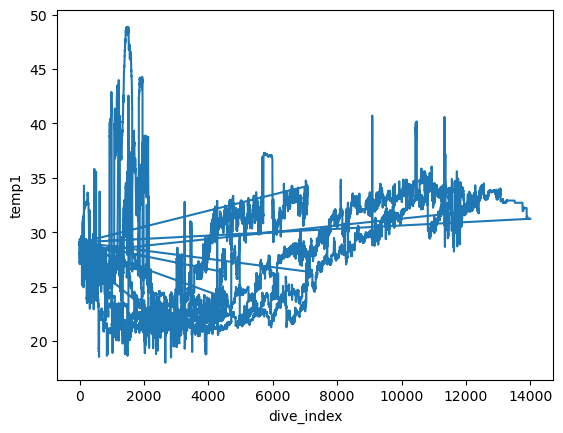

In [169]:
ds_dive_2_filtered = ds_dive_2_filtered.where(~((ds_dive_2_filtered.tag_id == 201411)&(ds_dive_2_filtered.temp1 <= 0) ), drop=True)
# ds_dive_2_filtered = ds_dive_2_filtered.where(~((ds_dive_2_filtered.tag_id == 203034)%(ds_dive_2_filtered.temp1 < 0) ), drop=True)
ds_dive_2_filtered = ds_dive_2_filtered.where(~((ds_dive_2_filtered.tag_id == 203040)&(ds_dive_2_filtered.temp1 < 0) ), drop=True)

ds_dive_2_filtered.temp1.plot()

### temp0 < 0

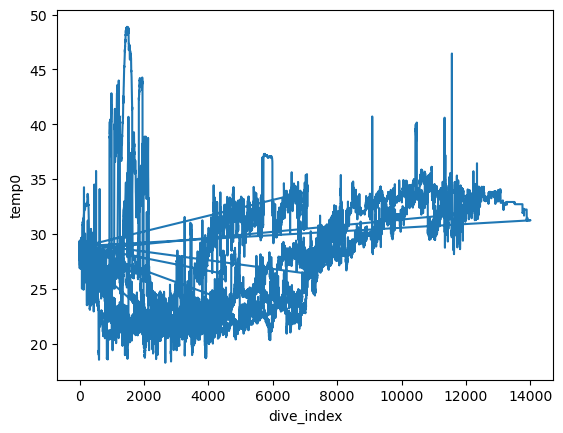

In [202]:
ds_dive_2_filtered = ds_dive_2_filtered.where(~((ds_dive_2_filtered.tag_id == 201411)&(ds_dive_2_filtered.temp0 < 0) ), drop=True)

ds_dive_2_filtered.temp0.plot()

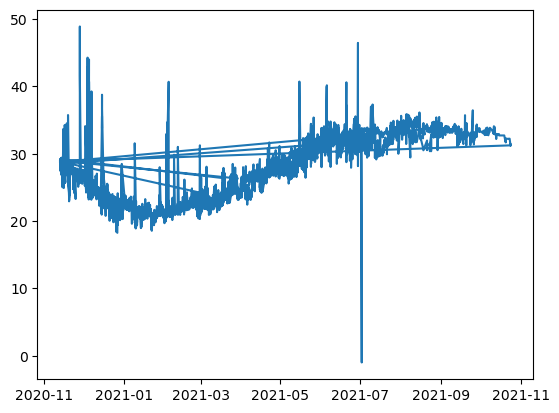

In [197]:
plt.plot(ds_dive_2_filtered.time,ds_dive_2_filtered.temp0)

In [200]:
ds_dive_2_filtered.where(ds_dive_2_filtered.temp0<0,drop=True).tag_id

<xarray.DataArray 'tag_id' (dive_index: 1)>
array([201411.])
Coordinates:
  * dive_index  (dive_index) float64 1.19e+04

(18600.0, 18605.0)

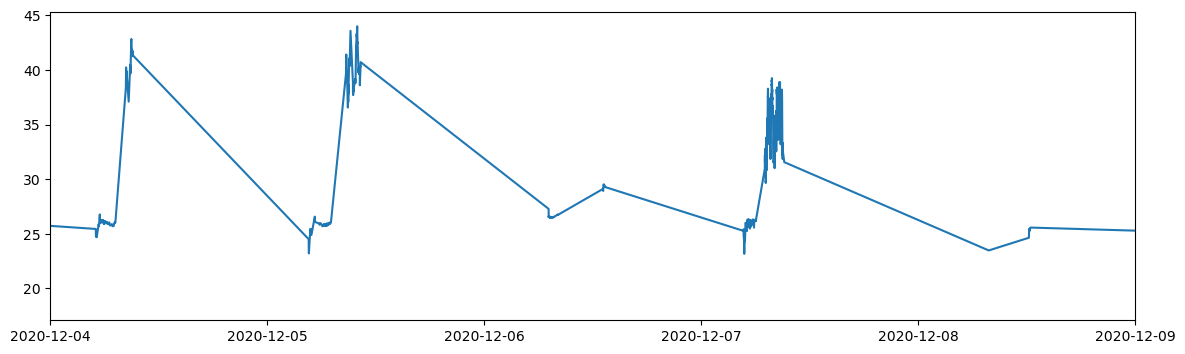

In [233]:
plt.figure(figsize=(14,4))
plt.plot(ds_dive_2_filtered.where(ds_dive_2_filtered.tag_id == 203014).time,ds_dive_2_filtered.where(ds_dive_2_filtered.tag_id == 203014).temp0)
plt.xlim([pd.Timestamp(2020, 12, 4), pd.Timestamp(2020, 12, 9)])

In [234]:
ds_obs

<xarray.Dataset>
Dimensions:   (t: 2930525)
Coordinates:
  * t         (t) datetime64[ns] 2020-11-02T20:11:05 ... 2021-08-14T19:26:56
Data variables:
    time      (t) datetime64[ns] 2020-11-02T20:11:05 ... 2021-08-14T19:26:56
    id        (t) int64 203018 203018 203018 203018 ... 201411 201411 201411
    lon       (t) float64 -123.3 0.0 nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0 0.0
    lat       (t) float64 44.56 0.0 nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0 0.0
    datatype  (t) object 'GPS' 'GPS' 'SEND_ALL2_10Hz_START' ... 'GPSS' 'GPS'
    depth     (t) float64 nan nan 0.58 0.64 0.69 0.72 ... nan nan nan nan nan
    temp      (t) float64 nan nan 14.67 14.43 14.25 ... nan nan nan nan nan

(18600.0, 18605.0)

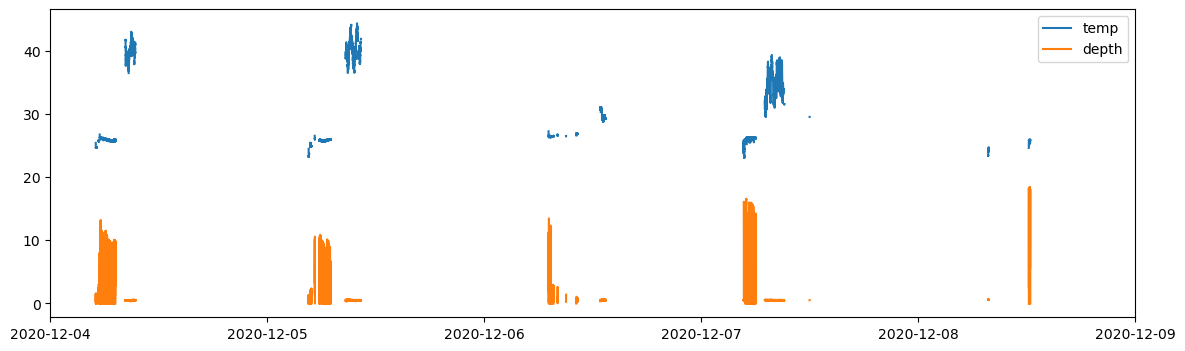

In [238]:
plt.figure(figsize=(14,4))
plt.plot(ds_obs.where(ds_obs.id == 203014).t,ds_obs.where(ds_obs.id == 203014).temp,label='temp')

plt.plot(ds_obs.where(ds_obs.id == 203014).t,ds_obs.where(ds_obs.id == 203014).depth,label='depth')
plt.legend()
plt.xlim([pd.Timestamp(2020, 12, 4), pd.Timestamp(2020, 12, 9)])

(18600.0, 18605.0)

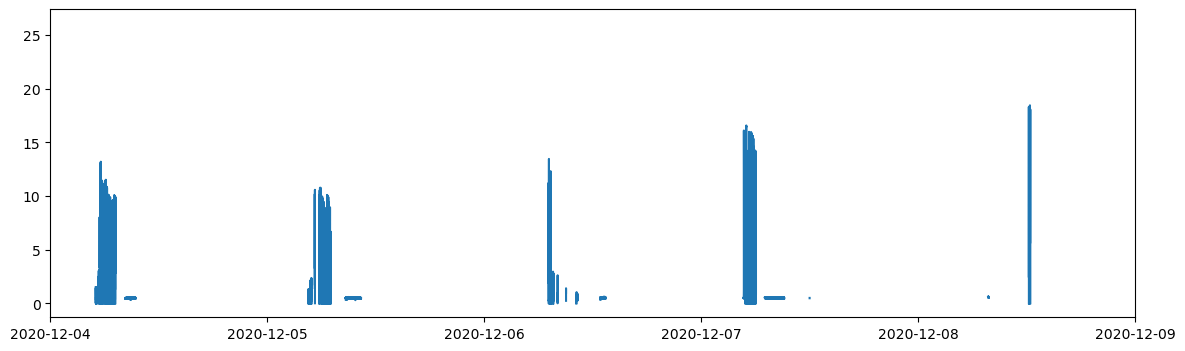

In [236]:
plt.figure(figsize=(14,4))
plt.plot(ds_obs.where(ds_obs.id == 203014).t,ds_obs.where(ds_obs.id == 203014).depth)
plt.xlim([pd.Timestamp(2020, 12, 4), pd.Timestamp(2020, 12, 9)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


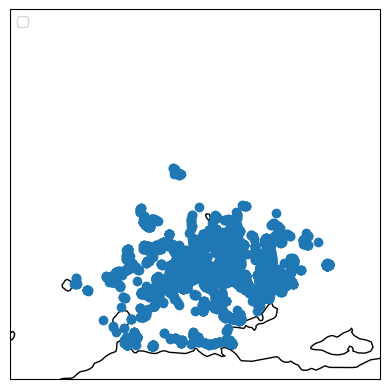

In [225]:
### OLD version
ax = plt.axes(projection=ccrs.PlateCarree())
# plt.plot(ds_obs.lon,ds_obs.lat,'o')

plt.plot(ds_dive_2_filtered.where(ds_dive_2_filtered.tag_id == 203014).lon,ds_dive_2_filtered.where(ds_dive_2_filtered.tag_id == 203014).lat,'o')

ax.coastlines()
ax.set_xlim(52,54)
ax.set_ylim(24,26)
# ax.set_xticks(np.arange(47,58,2), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(22,33,2), crs=ccrs.PlateCarree())
ax.legend(loc = "upper left")

(24.0, 26.0)

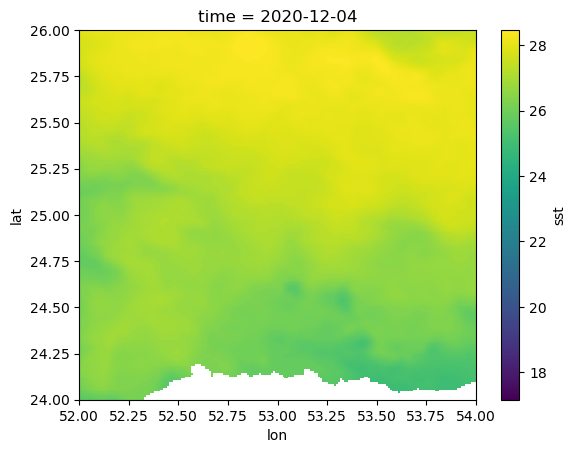

In [249]:
ds_mur_sec1.sel(time=pd.Timestamp(2020, 12, 4),method='nearest').plot()

plt.xlim(52,54)
plt.ylim(24,26)

In [250]:
ds_obs

<xarray.Dataset>
Dimensions:   (t: 2930525)
Coordinates:
  * t         (t) datetime64[ns] 2020-11-02T20:11:05 ... 2021-08-14T19:26:56
Data variables:
    time      (t) datetime64[ns] 2020-11-02T20:11:05 ... 2021-08-14T19:26:56
    id        (t) int64 203018 203018 203018 203018 ... 201411 201411 201411
    lon       (t) float64 -123.3 0.0 nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0 0.0
    lat       (t) float64 44.56 0.0 nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0 0.0
    datatype  (t) object 'GPS' 'GPS' 'SEND_ALL2_10Hz_START' ... 'GPSS' 'GPS'
    depth     (t) float64 nan nan 0.58 0.64 0.69 0.72 ... nan nan nan nan nan
    temp      (t) float64 nan nan 14.67 14.43 14.25 ... nan nan nan nan nan

## interpolate the data

In [203]:
# fmm2=ds_mur_sec1.interp(lon=ds_dive_2_filtered.lon,lat=ds_dive_2_filtered.lat,time=ds_dive_2_filtered.time) #original
fmm2=ds_mur_sec1.interp(lon=ds_dive_2_filtered.lon,lat=ds_dive_2_filtered.lat,time=ds_dive_2_filtered.time) #original
fmm2_0=ds_mur_sec1.interp(lon=ds_dive_2.lon,lat=ds_dive_2.lat,time=ds_dive_2.time) #original

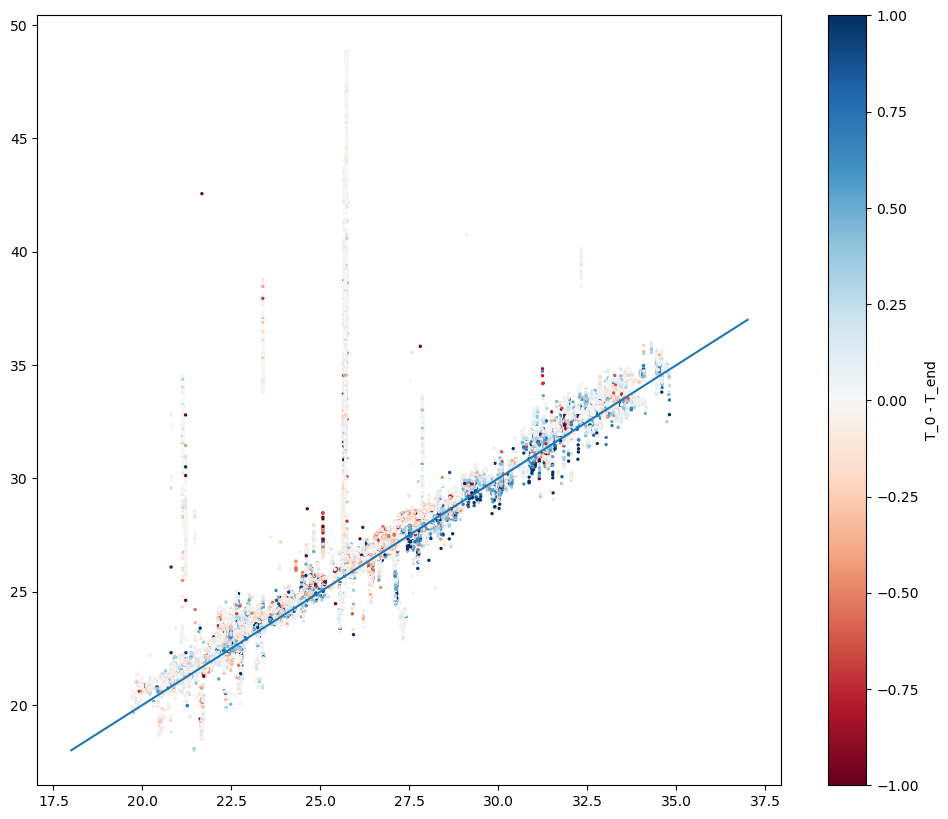

In [216]:
plt.figure(figsize=(12,10))

# plt.scatter(fmm2,ds_dive_2.where(ds_dive_2.dive_index>25000).temp1,c=ds_dive_2.temp0-ds_dive_2.temp1,cmap='RdBu',s=2,vmax=1,vmin=-1)
# plt.scatter(fmm2,ds_dive_2.where(ds_dive_2.dive_index<5000).temp1,c=ds_dive_2.temp0-ds_dive_2.temp1,cmap='RdBu',s=2,vmax=1,vmin=-1)
# plt.scatter(fmm2_0,ds_dive_2.where(ds_dive_2.temp1<50).temp1,c='k',cmap='RdBu',s=2,vmax=1,vmin=-1)
plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.temp1<50).temp1,c=ds_dive_2_filtered.temp0-ds_dive_2_filtered.temp1,cmap='RdBu',s=2,vmax=1,vmin=-1)
# plt.scatter(fmm2,ds_dive_2.temp0,c='r',cmap='RdBu',s=2,vmax=1,vmin=-1)

# plt.xlim([18, 37]),plt.ylim([18, 37])
plt.plot([18,37],[18,37])
plt.colorbar(label='T_0 - T_end')

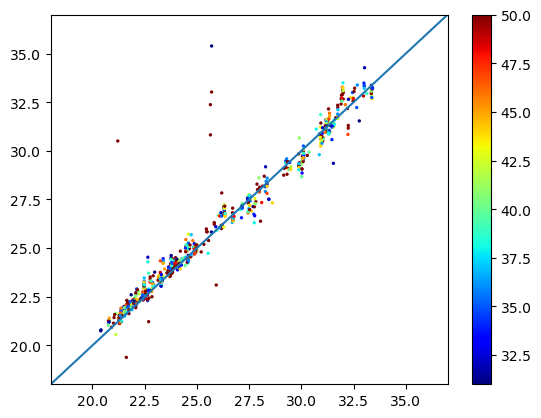

In [205]:
ds000 = ds_dive_2_filtered.where((ds_dive_2_filtered.temp0-ds_dive_2_filtered.temp1>0.8)&(ds_dive_2_filtered.rec_len>30))
# print(len(ds000))

plt.scatter(fmm2,ds000.temp1,c =ds000.rec_len, cmap='jet',s=2,vmax=50)
plt.plot([18,37],[18,37])
plt.xlim([18, 37]),plt.ylim([18, 37])

# plt.colorbar(label='T_surf - T_bot')
plt.colorbar()

/tmp/ipykernel_2645486/2466906955.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(fmm2,ds_dive_2_filtered.temp0,c='b',cmap='RdBu',s=2,vmax=1,vmin=-1)
/tmp/ipykernel_2645486/2466906955.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(fmm2,ds_dive_2_filtered.temp1,c='r',cmap='RdBu',s=2,vmax=1,vmin=-1)


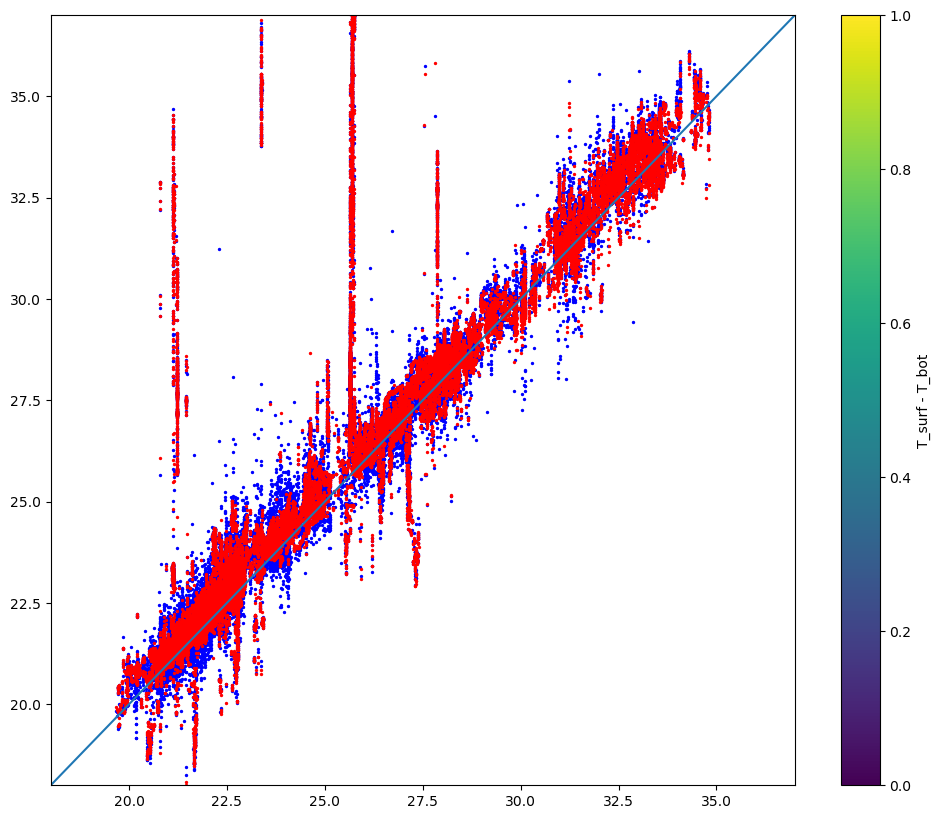

In [206]:
plt.figure(figsize=(12,10))

plt.scatter(fmm2,ds_dive_2_filtered.temp0,c='b',cmap='RdBu',s=2,vmax=1,vmin=-1)
plt.scatter(fmm2,ds_dive_2_filtered.temp1,c='r',cmap='RdBu',s=2,vmax=1,vmin=-1)


plt.xlim([18, 37]),plt.ylim([18, 37])
plt.plot([18,37],[18,37])
plt.colorbar(label='T_surf - T_bot')

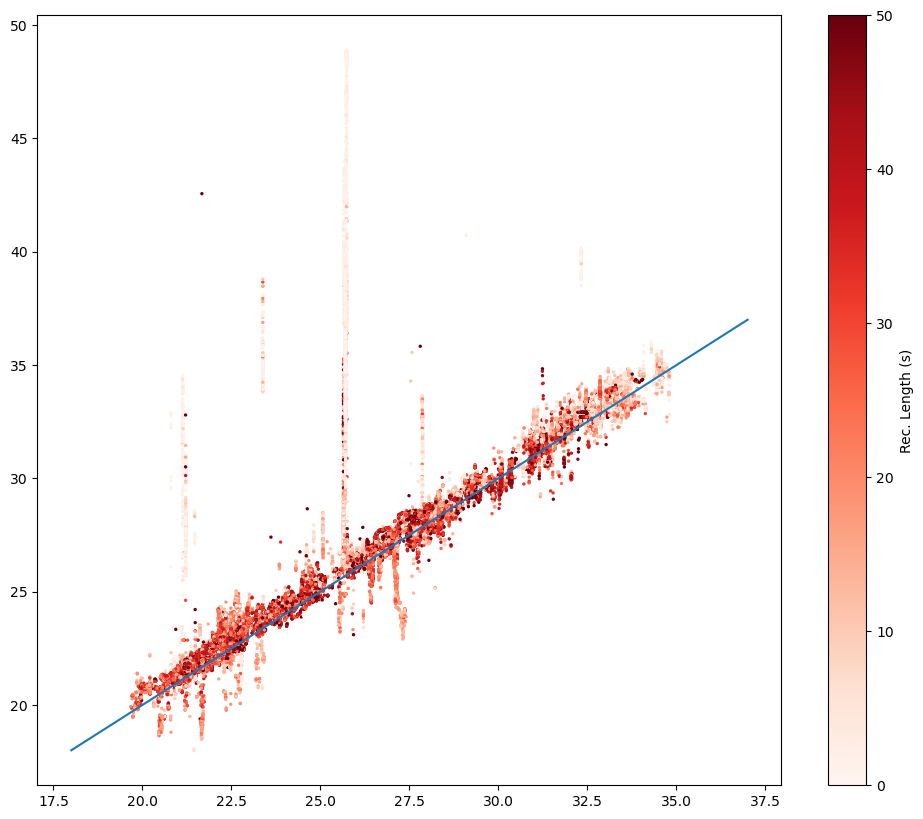

In [217]:
plt.figure(figsize=(12,10))

plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>0).temp1,c=ds_dive_2_filtered.rec_len,cmap='Reds',s=2,vmax=50,vmin=0)
# plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>30).temp1,c=ds_dive_2_filtered.rec_len,cmap='Reds',s=2,vmax=50,vmin=0)
# plt.scatter(fmm2,ds_dive_2.where((ds_dive_2.tag_id==237256)).temp1,color='g',s=2,vmax=50,vmin=0)

# plt.xlim([18, 39]),plt.ylim([18, 39])
plt.plot([18,37],[18,37])
plt.colorbar(label='Rec. Length (s)')

/tmp/ipykernel_2645486/600399509.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>70).temp1,color='r',s=2,vmax=50,vmin=0)


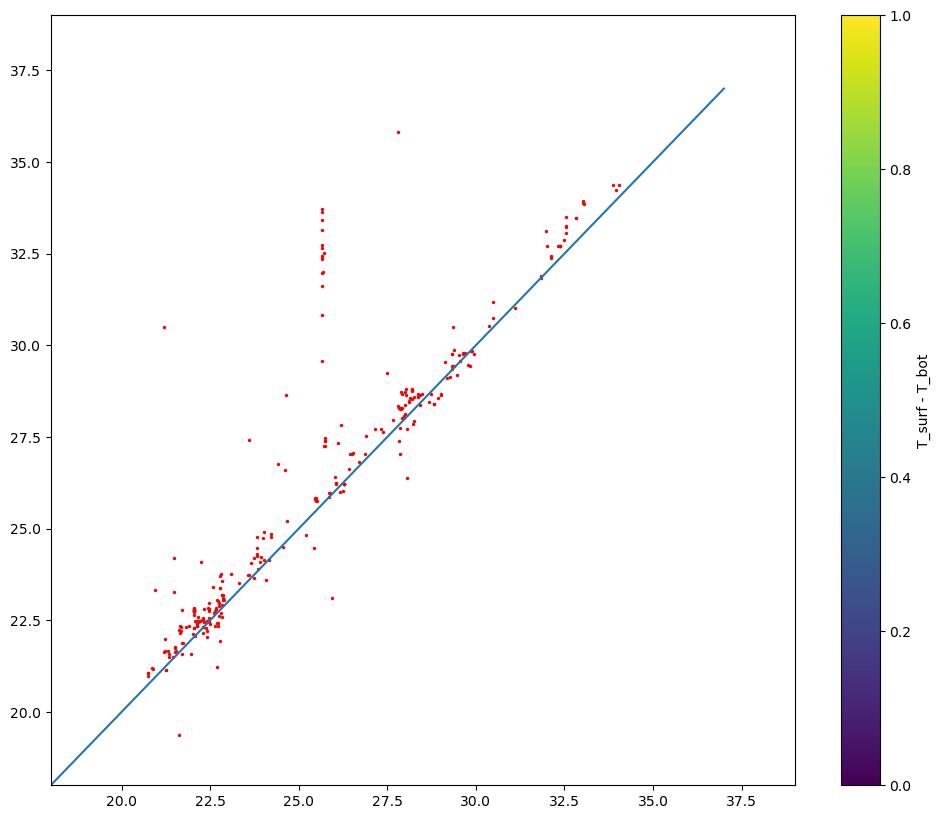

In [208]:
plt.figure(figsize=(12,10))

# plt.scatter(fmm2,ds_dive_2.where(ds_dive_2.rec_len>50).temp1,c=ds_dive_2.rec_len,cmap='Reds',s=2,vmax=50,vmin=0)
# plt.scatter(fmm2,ds_dive_2.where(ds_dive_2.rec_len>50).temp1,color='b',s=2,vmax=50,vmin=0)
# plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>60).temp1,color='g',s=2,vmax=50,vmin=0)
# plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>30).temp1,c=ds_dive_2_filtered.rec_len,s=2,vmax=50,vmin=0)
# plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>30).temp1,c=ds_dive_2_filtered.temp0-ds_dive_2_filtered.temp1,cmap='RdBu',s=2,vmax=1,vmin=-1)
# plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>70).temp0,color='k',s=2,vmax=50,vmin=0)
plt.scatter(fmm2,ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>70).temp1,color='r',s=2,vmax=50,vmin=0)
# plt.scatter(fmm2,ds_dive_2.where(ds_dive_2.rec_len>80).temp1,color='k',s=2,vmax=50,vmin=0)
# plt.scatter(fmm2,ds_dive_2.where(ds_dive_2.rec_len>80).temp1,color='r',s=2,vmax=50,vmin=0)

plt.xlim([18, 39]),plt.ylim([18, 39])
plt.plot([18,37],[18,37])
plt.colorbar(label='T_surf - T_bot')

In [245]:
tau = 4

T0 = ds_dive_2_filtered.temp0
Tm = ds_dive_2_filtered.temp1
tf = ds_dive_2_filtered.rec_len

eps = (1-np.exp(-tf/tau))/(1-T0/Tm*np.exp(-tf/tau))


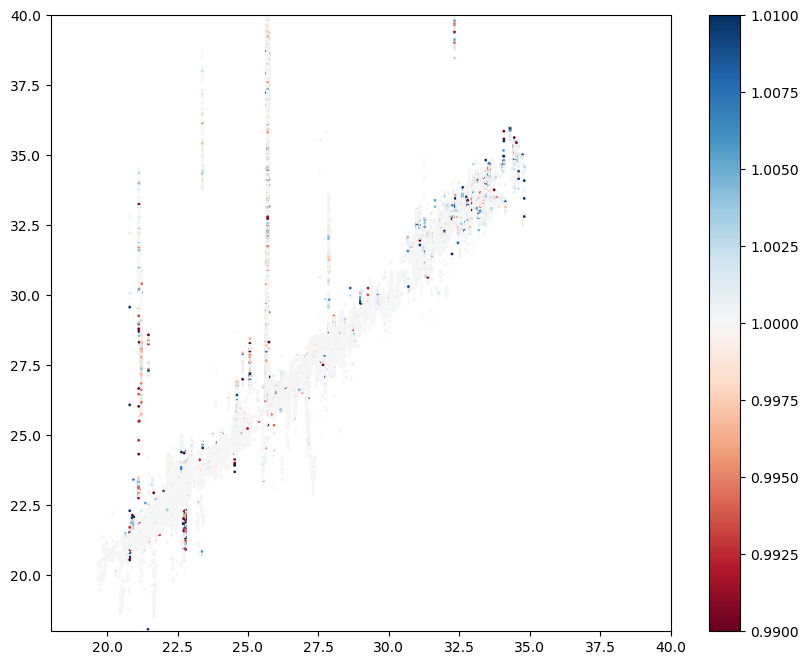

In [246]:
plt.figure(figsize=(10,8))
plt.scatter(fmm2,ds_dive_2_filtered.temp1,c=eps,s=1,vmin=0.99,vmax=1.01,cmap='RdBu',alpha=1)
plt.xlim([18, 40]),plt.ylim([18, 40])

plt.colorbar()

Standard Deviation: <xarray.DataArray ()>
array(2.69893244)
Root Mean Square Error: <xarray.DataArray ()>
array(2.84446121)
Standard Deviation (filtered): <xarray.DataArray ()>
array(2.41114028)
Root Mean Square Error (filtered): <xarray.DataArray ()>
array(2.52033403)


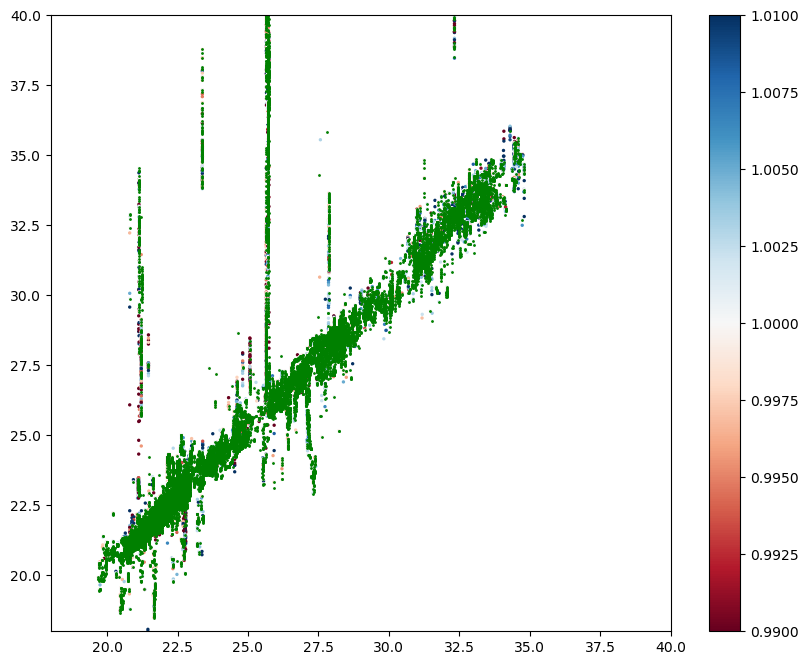

In [221]:
plt.figure(figsize=(10,8))
plt.scatter(fmm2,ds_dive_2_filtered.temp1,c=eps,s=2,vmin=0.99,vmax=1.01,cmap='RdBu')
plt.colorbar()
# plt.scatter(fmm2,ds_dive_2_filtered.where((eps>1.002)|(eps<0.998)).temp1,s=1,c='g')

plt.scatter(fmm2,ds_dive_2_filtered.where((eps<1.002)&(eps>0.998)).temp1,s=1,c='g')
plt.xlim([18, 40]),plt.ylim([18, 40])
std_dev = np.std(fmm2 - ds_dive_2_filtered.temp1)
print(f'Standard Deviation: {std_dev}')

rmse = np.sqrt(np.mean((fmm2 - ds_dive_2_filtered.temp1)**2))
print(f'Root Mean Square Error: {rmse}')

std_dev_filtered = np.std(fmm2 - ds_dive_2_filtered.where((eps < 1.002) & (eps > 0.998)).temp1)
print(f'Standard Deviation (filtered): {std_dev_filtered}')

rmse_filtered = np.sqrt(np.mean((fmm2 - ds_dive_2_filtered.where((eps < 1.002) & (eps > 0.998)).temp1)**2))
print(f'Root Mean Square Error (filtered): {rmse_filtered}')

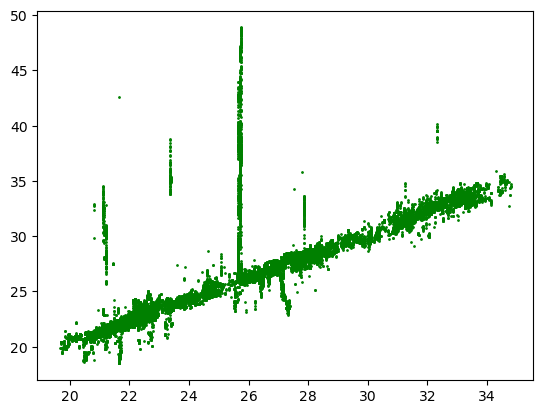

In [212]:

# plt.scatter(fmm2,ds_dive_2_filtered.where((eps>1.002)|(eps<0.998)).temp1,s=1,c='g')

plt.scatter(fmm2,ds_dive_2_filtered.where((eps<1.002)&(eps>0.998)).temp1,s=1,c='g')

/tmp/ipykernel_2645486/3674477829.py:3: RuntimeWarning: invalid value encountered in divide
  return (1 - np.exp(-t/tau)) / (1 - (T0 / T_obs) * np.exp(-t/tau))


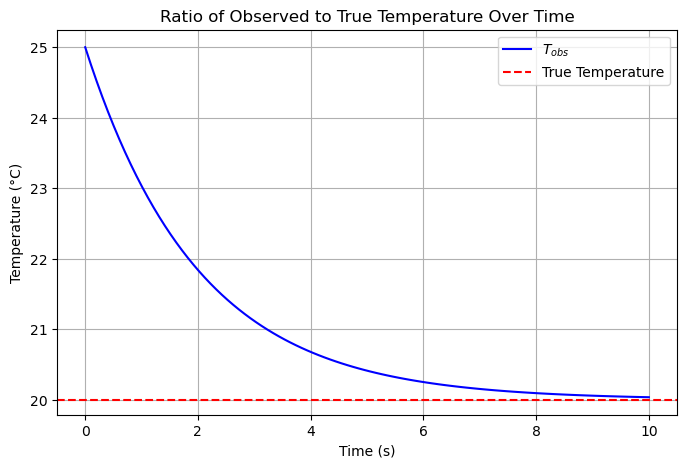

In [244]:

# Define function for the ratio
def temp_ratio(t, T0, T_obs, tau):
    return (1 - np.exp(-t/tau)) / (1 - (T0 / T_obs) * np.exp(-t/tau))

# Time range
t = np.linspace(0, 10, 100)  # Time from 0 to 10 seconds

# Example parameters
T0 = 25.0  # Initial sensor temperature
T_true = 20.0  # True water temperature
tau = 2.0  # Response time

# Compute T_obs from the model
T_obs = T_true + (T0 - T_true) * np.exp(-t/tau)

# Compute ratio
ratio = temp_ratio(t, T0, T_obs, tau)

# Plot
plt.figure(figsize=(8, 5))
# plt.plot(t, ratio, label=r'$\frac{T_{obs}}{T_{true}}$', color='b')
plt.plot(t, T_obs, label=r'${T_{obs}}$', color='b')
plt.axhline(T_true, linestyle='--', color='r', label='True Temperature')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.title("Ratio of Observed to True Temperature Over Time")
plt.legend()
plt.grid()
plt.show()

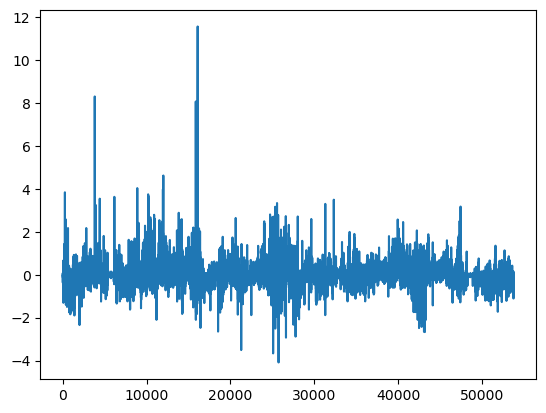

In [214]:
plt.plot(ds_dive_2_filtered.temp0-ds_dive_2_filtered.temp1)
# plt.plot(ds_dive_2.temp1)

In [221]:
ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len>70,drop=True)

<xarray.Dataset>
Dimensions:       (dive_index: 911)
Coordinates:
  * dive_index    (dive_index) float64 1.456e+04 1.608e+04 ... 1.389e+04
Data variables:
    tag_id        (dive_index) float64 2.372e+05 2.372e+05 ... 2.373e+05
    temp1         (dive_index) float64 19.88 20.91 20.73 ... 20.59 20.62 20.53
    temp0         (dive_index) float64 19.88 20.61 20.62 ... 20.46 20.02 20.51
    rec_len       (dive_index) float64 72.0 76.0 76.0 74.0 ... 73.0 75.0 72.0
    first_record  (dive_index) float64 3.988e+05 4.46e+05 ... 3.761e+05
    last_record   (dive_index) float64 3.989e+05 4.461e+05 ... 3.761e+05
    lon           (dive_index) float64 50.39 50.31 50.36 ... 50.53 50.42 50.62
    lat           (dive_index) float64 25.56 25.98 25.99 ... 25.5 25.68 25.41
    time          (dive_index) datetime64[ns] 2024-02-13T07:54:41 ... 2024-03...

Estimated Response Time (tau): 0.10 seconds
Case 1: Estimated True Water Temperature = 25.68
Case 1: Initial Temperature = 26.56
Case 1: Measured Temperature = 25.68
Case 1: response time = 39.00


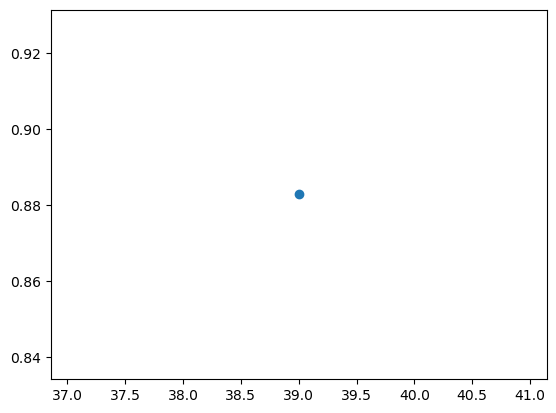

In [271]:
from scipy.optimize import minimize

# # Example dataset: each row is (T0, t_obs, T_obs)
# data = np.array([
#     [10.0, 1, 15.0],  # Case 1: (T0, t_obs, T_obs)
#     [12.0, 2, 17.5],  # Case 2
#     [11.0, 3, 18.2],  # Case 3
#     [9.0, 1.5, 14.5], # Case 4
# ])

# # Extract values
# T0_all = data[:, 0]  # Initial sensor temperatures
# t_obs_all = data[:, 1]  # Time after sensor in water
# T_obs_all = data[:, 2]  # Observed temperatures
# n_cases = len(data)  # Number of cases

# data = ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len<10,drop=True)
data = ds000.dropna(dim='dive_index')
t_obs_all = data.rec_len.values[0:1]
T_obs_all = data['temp1'].values[0:1]
T0_all = data['temp0'].values[0:1]
n_cases = len(t_obs_all)  # Number of cases

# Objective function: minimizes the squared error
def objective(params):
    tau = params[0]  # First parameter is the shared tau
    T_true_all = params[1:]  # Remaining parameters are T_true for each case
    model_T_obs = T_true_all + (T0_all - T_true_all) * np.exp(-t_obs_all / tau)
    return np.sum((T_obs_all - model_T_obs) ** 2)  # Sum of squared errors

# Initial guesses: tau=5s, each T_true starts from T_obs (reasonable assumption)
initial_guess = np.concatenate(([0.02], T_obs_all))

# Run optimization
result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=[(0.1, None)] + [(None, None)] * n_cases)

# Extract fitted tau and T_true values
tau_fit = result.x[0]
T_true_fit = result.x[1:]

print(f"Estimated Response Time (tau): {tau_fit:.2f} seconds")
for i, T_true in enumerate(T_true_fit):
    print(f"Case {i+1}: Estimated True Water Temperature = {T_true:.2f}")
    print(f"Case {i+1}: Initial Temperature = {T0_all[i]:.2f}")
    print(f"Case {i+1}: Measured Temperature = {T_obs_all[i]:.2f}")
    print(f"Case {i+1}: response time = {t_obs_all[i]:.2f}")

plt.plot(t_obs_all,T0_all-T_obs_all,'o')

In [307]:
import numpy as np
from scipy.optimize import curve_fit

# Example dataset: each row is (T0, t_obs, T_obs)
# data = np.array([
#     [10.0, 10, 15.0],  # Case 1: (T0, t_obs, T_obs)
#     [12.0, 20, 17.5],  # Case 2
#     [11.0, 30, 18.2],  # Case 3
#     [9.0, 15, 14.5], # Case 4
# ])

# Extract values
# T0_all = data[:, 0]  # Initial sensor temperatures
# t_obs_all = data[:, 1]  # Time after sensor in water
# T_obs_all = data[:, 2]  # Observed temperatures

# data = ds_dive_2_filtered.where(ds_dive_2_filtered.rec_len<10,drop=True)
data = ds000.dropna(dim='dive_index')
t_obs_all = data.rec_len.values[0:]
T_obs_all = (data['temp1'].values-data['temp0'].values)[0:]
T0_all = data['temp0'].values[0:]*0

# Define the model function
def temperature_model(t, tau, C):
    return T0_all + C * np.exp(-t / tau)

# Initial guess for tau and C
initial_guess = [0.000001, np.mean(T_obs_all)]  # Guess tau=5s, C=mean observed temp

# Fit the model
popt, pcov = curve_fit(temperature_model, t_obs_all, T_obs_all, p0=initial_guess)

# Extract fitted parameters
tau_fit, C_fit = popt

print(f"Estimated Response Time (tau): {tau_fit:.2f} seconds")
print(f"Estimated Final Temperature (C): {C_fit:.2f}")
for i in range(len(T0_all)):
    print(i)
    print(f"Case {i+1}: Initial Temperature = {T0_all[i]:.2f}")
    print(f"Case {i+1}: Measured Temperature = {T_obs_all[i]:.2f}")
    print(f"Case {i+1}: response time = {t_obs_all[i]:.2f}")

    # Calculate the predicted temperatures using the fitted model
T_predict = temperature_model(t_obs_all, tau_fit, C_fit)

# Print the predicted temperatures
for i in range(len(T_predict)):
    print(f"Case {i+1}: Predicted Temperature = {T_predict[i]:.2f}")

Estimated Response Time (tau): 0.00 seconds
Estimated Final Temperature (C): -1.27
0
Case 1: Initial Temperature = 0.00
Case 1: Measured Temperature = -0.88
Case 1: response time = 39.00
1
Case 2: Initial Temperature = 0.00
Case 2: Measured Temperature = -0.84
Case 2: response time = 37.00
2
Case 3: Initial Temperature = 0.00
Case 3: Measured Temperature = -1.06
Case 3: response time = 36.00
3
Case 4: Initial Temperature = 0.00
Case 4: Measured Temperature = -0.94
Case 4: response time = 31.00
4
Case 5: Initial Temperature = 0.00
Case 5: Measured Temperature = -1.03
Case 5: response time = 38.00
5
Case 6: Initial Temperature = 0.00
Case 6: Measured Temperature = -0.91
Case 6: response time = 33.00
6
Case 7: Initial Temperature = 0.00
Case 7: Measured Temperature = -0.84
Case 7: response time = 32.00
7
Case 8: Initial Temperature = 0.00
Case 8: Measured Temperature = -0.86
Case 8: response time = 33.00
8
Case 9: Initial Temperature = 0.00
Case 9: Measured Temperature = -1.18
Case 9: res

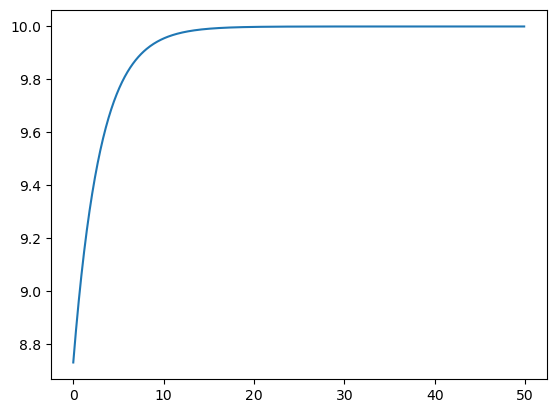

In [309]:
t00 = np.arange(0, 50, 0.1)
tau0 = 3
y00= 10 + C_fit*np.exp(-t00/tau0)
plt.plot(t00,y00)

# all tags